In [8]:
import os
import random
import pyreadr

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense, LSTM, TimeDistributed, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from keras.callbacks import EarlyStopping
import tensorflow as tf

import dues_utilities as utils
import matplotlib.pyplot as plt

import importlib
importlib.reload(utils)

<module 'dues_utilities' from 'C:\\Users\\benchoi\\Projects\\dues\\ml\\dues_utilities.py'>

In [2]:
tf.random.set_seed(77)
os.environ['PYTHONHASHSEED'] = str(77)
np.random.seed(77)
random.seed(77)

# Data read and formatting

PATH_RETROFIT_ROOT = "../data/all/"
PATH_ENERGY_BASELINE = "../data/all/building_energy_retrofit_baseline.csv"
PATH_ENERGY_FULL = PATH_RETROFIT_ROOT + "building_energy_retrofit_full.csv"
PATH_ENERGY_LIGHT = PATH_RETROFIT_ROOT + "building_energy_retrofit_light.csv"
PATH_ENERGY_WINDOW = PATH_RETROFIT_ROOT + "building_energy_retrofit_window.csv"
PATH_ENERGY_FEATURIZED = "../data/building_energy_featurized.csv"
PATH_DISTANCES = "D:/smud/smud_distances.csv"
PATH_ENERGY_ACTUAL = "../data/building_energy_actual.csv"
PATH_ENERGY_ACTUAL_STATIONARY = "../data/building_energy_actual_stationary.csv"
PATH_ENERGY_SIM = "../data/building_energy_sim.csv"

energy_dtype = {
    'apn': str, 
    'year': np.float32, 
    'month': np.float32, 
    'day': np.float32, 
    'hour': np.float32, 
    'kwh': np.float32
}

energy_retrofit_baseline = pd.read_csv(PATH_ENERGY_BASELINE, dtype=energy_dtype)
energy_retrofit_full = pd.read_csv(PATH_ENERGY_FULL, dtype=energy_dtype)
energy_retrofit_light = pd.read_csv(PATH_ENERGY_LIGHT, dtype=energy_dtype)
energy_retrofit_window = pd.read_csv(PATH_ENERGY_WINDOW, dtype=energy_dtype)

# energy_featurized = pd.read_csv(PATH_ENERGY_FEATURIZED, dtype=np.float32)
# dist = pd.read_csv(PATH_DISTANCES, dtype=str)
energy_actual = pd.read_csv(PATH_ENERGY_ACTUAL_STATIONARY, dtype=energy_dtype)
# energy_sim = pd.read_csv(PATH_ENERGY_SIM, dtype=energy_dtype)

## Supervised Experiments

In [57]:
# Combined simulation and observed data into properly formatted dataframe
energy = utils.get_energy_df(energy_retrofit_baseline, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building')

# Number of timesteps before 't' model uses in each prediction step
timesteps = 24

# Define folds in 6 month increments
# fold_1 = ['year <= 2016 and month < 7', 'year == 2016 and month >= 7', 'year == 2017 and month < 7']
# fold_2 = ['year <= 2016', 'year == 2017 and month < 7', 'year == 2017 and month >= 7']
# fold_3 = ['(year == 2017 and month < 7) or year <= 2016', 'year == 2017 and month >= 7', 'year == 2018 and month < 7']
# fold_4 = ['year <= 2017', 'year == 2018 and month < 7', 'year == 2018 and month >= 7']
# folds = [fold_1, fold_2, fold_3, fold_4]

fold_1 = ['year <= 2016 and month < 7', 'year == 2016 and month >= 7', 'year == 2017 and month < 7']
fold_2 = ['year <= 2016', 'year == 2017 and month < 7', 'year == 2017 and month >= 7']
fold_3 = ['(year == 2017 and month < 7) or year <= 2016', 'year == 2017 and month >= 7', 'year == 2018']
#fold_4 = ['year <= 2017', 'year == 2018 and month < 7', 'year == 2018 and month >= 7']
folds = [fold_1, fold_2, fold_3]

train_folds, val_folds, test_folds = utils.make_supervised_folds(folds, energy, timesteps, None)
# Callback Functions
callbacks = []
callbacks.append(EarlyStopping(patience=2))

# Additional Parameters
verbose = 0
N = 20

Retrieving DUE-S Energy Data...
Processing Fold #1...
Train: (125257, 696) (125257,)
Val: (127345, 696) (127345,)
Test: (125257, 696) (125257,)
Processing Fold #2...
Train: (253321, 696) (253321,)
Val: (125257, 696) (125257,)
Test: 

KeyboardInterrupt: 

### Linear Regression

In [120]:
lr_model = LinearRegression()

metrics = utils.walk_forward_cv(lr_model, train_folds, val_folds, test_folds, simple=True)

print("\nOverall Validation:")
utils.print_metrics(*metrics[0])
print("\nOverall Test:")
utils.print_metrics(*metrics[1])

# Overall Validation:
# MAPE: 296.4169502258301
# MSE: 14502.9697265625
# CV(RMSE): 69.11879353867344
# MBE: 48.46234130859375

# Overall Test:
# MAPE: 131.40065670013428
# MSE: 8159.7578125
# CV(RMSE): 54.65910383532422
# MBE: 3.940553665161133


Fold #1

Validation:
MAPE: 290.18714427948
MSE: 14365.689
CV(RMSE): 68.7097814279015
MBE: 46.435257

Test:
MAPE: 130.1529049873352
MSE: 8149.3457
CV(RMSE): 54.6380541609646
MBE: 3.6186194

Fold #2

Validation:
MAPE: 112.71957159042358
MSE: 8822.563
CV(RMSE): 56.850103426817974
MBE: 4.877899

Test:
MAPE: 109.28900241851807
MSE: 11550.531
CV(RMSE): 60.876259260056344
MBE: -3.9707053

Fold #3

Validation:
MAPE: 119.36447620391846
MSE: 11668.401
CV(RMSE): 61.186086693773
MBE: -1.2953436

Test:
MAPE: 93.3106780052185
MSE: 7511.4736
CV(RMSE): 52.31195716403482
MBE: 0.30554175

Fold #4

Validation:
MAPE: 92.2036349773407
MSE: 7633.94
CV(RMSE): 52.73667979640796
MBE: 3.7088547

Test:
MAPE: 115.003502368927
MSE: 11126.904
CV(RMSE): 59.94105442706554
MBE: -4.1143913

4-Fold Average

Validation:
MAPE: 153.61870676279068
MSE: 10622.648559570312
CV(RMSE): 59.870662836225115
MBE: 13.431666791439056

Test:
MAPE: 111.9390219449997
MSE: 9584.563720703125
CV(RMSE): 56.94183125303033
MBE: -1.04023385047

In [121]:
# knn_model = KNeighborsRegressor(n_neighbors=1)
# # utils.walk_forward_cv(knn_model, train_folds, val_folds, test_folds, simple=True)

# metrics = np.zeros((2,4))

# for i in range(N):
#     print("-----Experiment #" + str(i + 1) + "-----")
#     metrics = metrics + utils.walk_forward_cv(knn_model, train_folds, val_folds, test_folds, simple=True) / N

# print("\nOverall Validation:")
# print_metrics(*metrics[0])
# print("\nOverall Test:")
# print_metrics(*metrics[1])

# 4-Fold Average

# Validation:
# MAPE: 36.308494955301285
# MSE: 7894.553466796875
# CV(RMSE): 50.844112055883855
# MBE: 15.018418371677399

# Test:
# MAPE: 35.82461327314377
# MSE: 5369.8382568359375
# CV(RMSE): 42.84330763067136
# MBE: 4.418466746807098

### ANN

-----Experiment #1-----

Fold #1
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


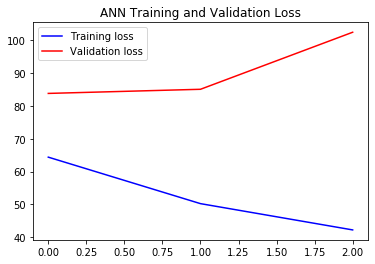


Validation:
MAPE: 102.51399278640747
MSE: 42377.016
CV(RMSE): 118.01045882969679
MBE: -77.47066

Test:
MAPE: 43.500566482543945
MSE: 40786.46
CV(RMSE): 122.23395831490109
MBE: -90.30745

Fold #2


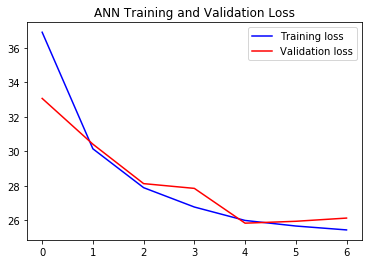


Validation:
MAPE: 26.136648654937744
MSE: 13342.04
CV(RMSE): 69.91091385199003
MBE: -33.175903

Test:
MAPE: 30.65480887889862
MSE: 18403.232
CV(RMSE): 76.84117936499335
MBE: -46.6629

Fold #3


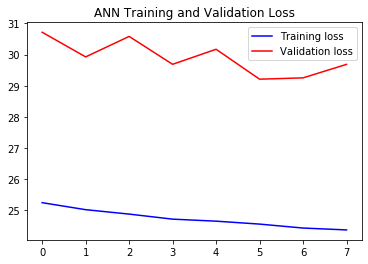


Validation:
MAPE: 29.68728244304657
MSE: 16332.8125
CV(RMSE): 72.38981385375561
MBE: -42.673412

Test:
MAPE: 24.864740669727325
MSE: 10290.835
CV(RMSE): 61.22992593705976
MBE: -32.375256

Fold #4


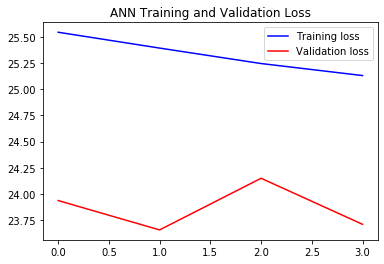


Validation:
MAPE: 23.71019273996353
MSE: 9708.455
CV(RMSE): 59.472128403270204
MBE: -29.026922

Test:
MAPE: 25.15253722667694
MSE: 15423.003
CV(RMSE): 70.57025085901238
MBE: -40.621048

4-Fold Average

Validation:
MAPE: 45.51202915608883
MSE: 20440.080810546875
CV(RMSE): 79.94582873467814
MBE: -45.58672380447388

Test:
MAPE: 31.043163314461708
MSE: 21225.8828125
CV(RMSE): 82.71882861899165
MBE: -52.49166297912598
-----Experiment #2-----

Fold #1
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


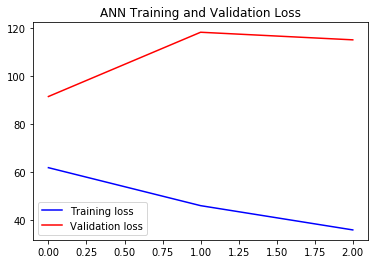


Validation:
MAPE: 115.10347127914429
MSE: 32974.184
CV(RMSE): 104.09799176229173
MBE: -50.99352

Test:
MAPE: 38.27354907989502
MSE: 31675.457
CV(RMSE): 107.71973742757861
MBE: -70.48269

Fold #2


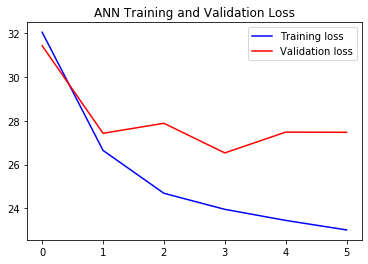


Validation:
MAPE: 27.47691571712494
MSE: 11701.936
CV(RMSE): 65.47306848408738
MBE: -28.095903

Test:
MAPE: 29.145339131355286
MSE: 16520.887
CV(RMSE): 72.80541061880007
MBE: -40.914433

Fold #3


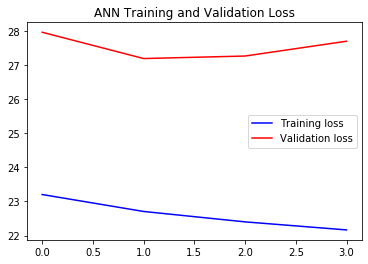


Validation:
MAPE: 27.695733308792114
MSE: 14342.018
CV(RMSE): 67.8347317357
MBE: -37.33789

Test:
MAPE: 23.515281081199646
MSE: 8688.899
CV(RMSE): 56.26272818635686
MBE: -27.213337

Fold #4


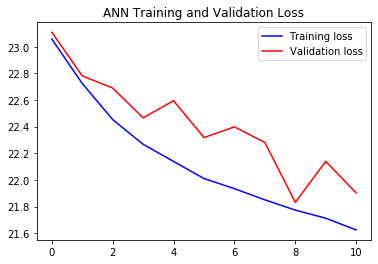


Validation:
MAPE: 21.90273255109787
MSE: 5642.1514
CV(RMSE): 45.33783664303019
MBE: -19.18536

Test:
MAPE: 22.2066730260849
MSE: 9925.915
CV(RMSE): 56.61381866246216
MBE: -28.949112

4-Fold Average

Validation:
MAPE: 48.0447132140398
MSE: 16165.072021484375
CV(RMSE): 70.68590715627732
MBE: -33.90316820144653

Test:
MAPE: 28.285210579633713
MSE: 16702.78955078125
CV(RMSE): 73.35042372379942
MBE: -41.889892578125
-----Experiment #3-----

Fold #1
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


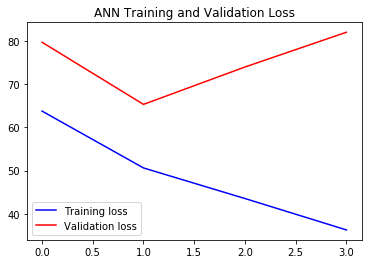


Validation:
MAPE: 81.96723461151123
MSE: 36932.52
CV(RMSE): 110.16910071261853
MBE: -68.24517

Test:
MAPE: 38.43470811843872
MSE: 34497.227
CV(RMSE): 112.41542948219357
MBE: -76.51334

Fold #2


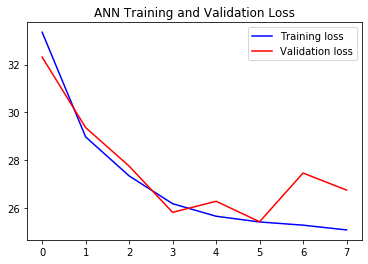


Validation:
MAPE: 26.759469509124756
MSE: 12921.587
CV(RMSE): 68.80052781940361
MBE: -32.01327

Test:
MAPE: 30.031734704971313
MSE: 18070.006
CV(RMSE): 76.14232822520401
MBE: -46.391087

Fold #3


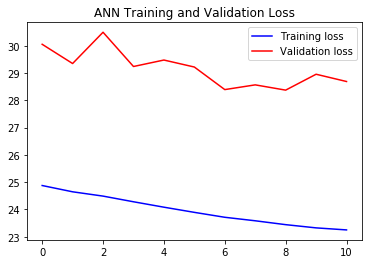


Validation:
MAPE: 28.686439990997314
MSE: 14757.027
CV(RMSE): 68.80918815048139
MBE: -40.80746

Test:
MAPE: 23.64046424627304
MSE: 8831.241
CV(RMSE): 56.7217073231832
MBE: -27.279488

Fold #4


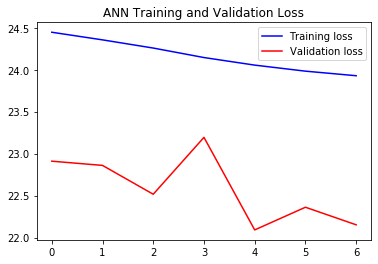


Validation:
MAPE: 22.152142226696014
MSE: 7970.3022
CV(RMSE): 53.885983448568545
MBE: -25.683775

Test:
MAPE: 23.677818477153778
MSE: 12975.275
CV(RMSE): 64.72848983422544
MBE: -36.723446

4-Fold Average

Validation:
MAPE: 39.89132158458233
MSE: 18145.359008789062
CV(RMSE): 75.41620003276802
MBE: -41.687419414520264

Test:
MAPE: 28.946181386709213
MSE: 18593.437255859375
CV(RMSE): 77.50198871620155
MBE: -46.72684097290039
-----Experiment #4-----

Fold #1
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


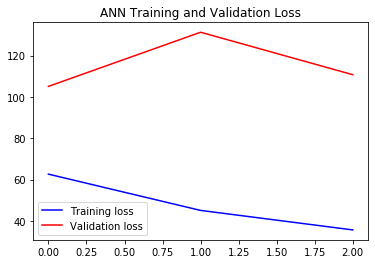


Validation:
MAPE: 110.75189113616943
MSE: 33205.41
CV(RMSE): 104.46233545074061
MBE: -51.800163

Test:
MAPE: 39.06219005584717
MSE: 31710.826
CV(RMSE): 107.77985963358148
MBE: -70.18687

Fold #2


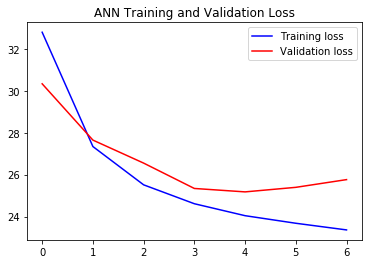


Validation:
MAPE: 25.76332986354828
MSE: 10786.247
CV(RMSE): 62.85922556318622
MBE: -27.132723

Test:
MAPE: 29.15571630001068
MSE: 15408.206
CV(RMSE): 70.3109614019512
MBE: -41.18896

Fold #3


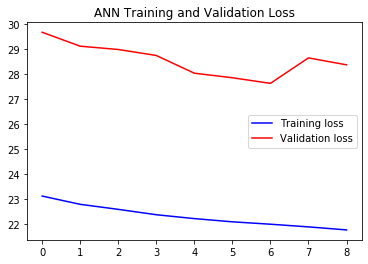


Validation:
MAPE: 28.367716073989868
MSE: 11637.116
CV(RMSE): 61.10400364252723
MBE: -32.018833

Test:
MAPE: 23.00359159708023
MSE: 6757.9487
CV(RMSE): 49.61875305771192
MBE: -22.504776

Fold #4


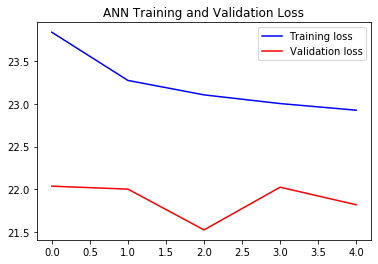


Validation:
MAPE: 21.82036191225052
MSE: 6377.1743
CV(RMSE): 48.200610216147076
MBE: -19.96213

Test:
MAPE: 23.03289771080017
MSE: 10872.982
CV(RMSE): 59.25316387427673
MBE: -31.86035

4-Fold Average

Validation:
MAPE: 46.675824746489525
MSE: 15501.486938476562
CV(RMSE): 69.15654371815029
MBE: -32.72846221923828

Test:
MAPE: 28.563598915934563
MSE: 16187.490844726562
CV(RMSE): 71.74068449188033
MBE: -41.43523836135864
-----Experiment #5-----

Fold #1
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


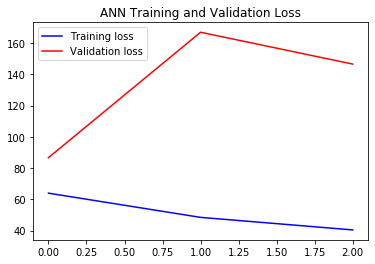


Validation:
MAPE: 146.60718441009521
MSE: 38243.8
CV(RMSE): 112.10780591394571
MBE: -58.63015

Test:
MAPE: 42.70063042640686
MSE: 37289.55
CV(RMSE): 116.87656181514019
MBE: -82.468895

Fold #2


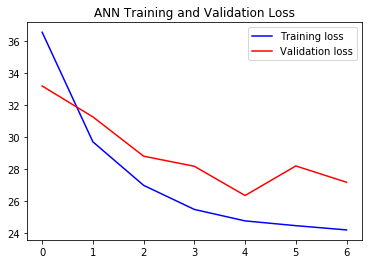


Validation:
MAPE: 27.18125581741333
MSE: 13202.231
CV(RMSE): 69.54365583278675
MBE: -33.177185

Test:
MAPE: 29.580214619636536
MSE: 18187.629
CV(RMSE): 76.38973554771746
MBE: -45.097996

Fold #3


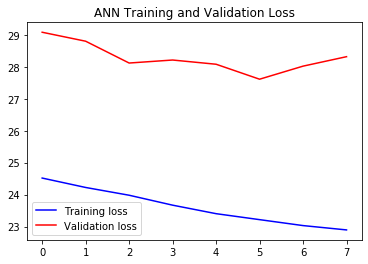


Validation:
MAPE: 28.31825017929077
MSE: 15369.583
CV(RMSE): 70.2227806785296
MBE: -40.260086

Test:
MAPE: 24.508723616600037
MSE: 9485.92
CV(RMSE): 58.78657465532587
MBE: -29.888214

Fold #4


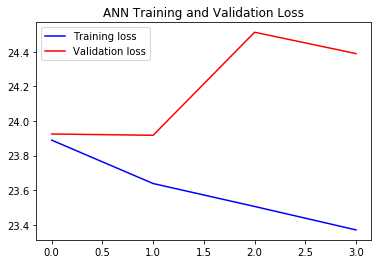


Validation:
MAPE: 24.389465153217316
MSE: 8523.571
CV(RMSE): 55.72488863297436
MBE: -26.32627

Test:
MAPE: 24.569982290267944
MSE: 13550.78
CV(RMSE): 66.14840078203335
MBE: -36.49471

4-Fold Average

Validation:
MAPE: 56.62403889000416
MSE: 18834.796630859375
CV(RMSE): 76.8997827645591
MBE: -39.59842252731323

Test:
MAPE: 30.339887738227844
MSE: 19628.469970703125
CV(RMSE): 79.55031820005422
MBE: -48.48745346069336
-----Experiment #6-----

Fold #1
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


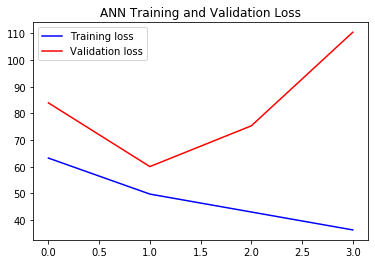


Validation:
MAPE: 110.43373346328735
MSE: 35834.266
CV(RMSE): 108.5186986810692
MBE: -61.768047

Test:
MAPE: 39.33015763759613
MSE: 34264.164
CV(RMSE): 112.03505263140396
MBE: -77.1319

Fold #2


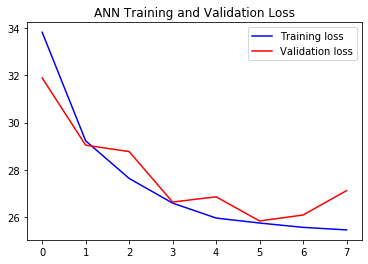


Validation:
MAPE: 27.12184190750122
MSE: 12451.929
CV(RMSE): 67.53861720403852
MBE: -31.497238

Test:
MAPE: 30.336016416549683
MSE: 17439.707
CV(RMSE): 74.80257759968484
MBE: -44.26115

Fold #3


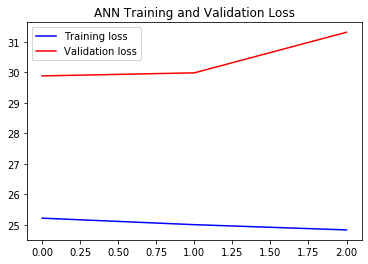


Validation:
MAPE: 31.31396174430847
MSE: 16337.025
CV(RMSE): 72.3991526698945
MBE: -41.35168

Test:
MAPE: 25.904202461242676
MSE: 10423.528
CV(RMSE): 61.623417541982754
MBE: -32.57804

Fold #4


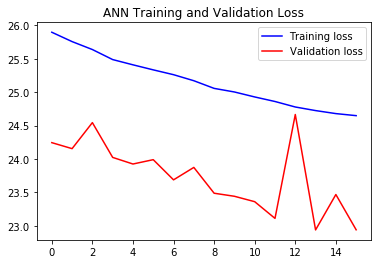


Validation:
MAPE: 22.939912974834442
MSE: 9276.553
CV(RMSE): 58.1342044496708
MBE: -29.8194

Test:
MAPE: 24.458302557468414
MSE: 14705.722
CV(RMSE): 68.90970025870085
MBE: -39.218555

4-Fold Average

Validation:
MAPE: 47.95236252248287
MSE: 18474.943115234375
CV(RMSE): 76.64766825116826
MBE: -41.10909175872803

Test:
MAPE: 30.007169768214226
MSE: 19208.2802734375
CV(RMSE): 79.3426870079431
MBE: -48.29741096496582
-----Experiment #7-----

Fold #1
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


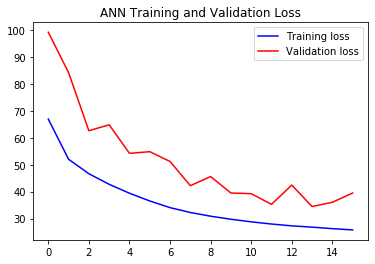


Validation:
MAPE: 39.483073353767395
MSE: 22018.506
CV(RMSE): 85.06467292911175
MBE: -52.300663

Test:
MAPE: 30.95669150352478
MSE: 18376.031
CV(RMSE): 82.0464379855607
MBE: -47.048683

Fold #2


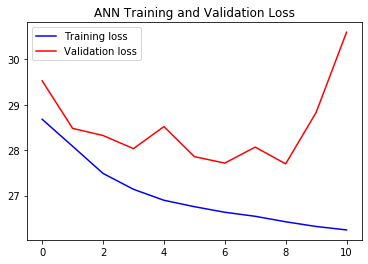


Validation:
MAPE: 30.600130558013916
MSE: 13542.376
CV(RMSE): 70.4338246607436
MBE: -33.464172

Test:
MAPE: 31.08575940132141
MSE: 18261.508
CV(RMSE): 76.54473137355619
MBE: -46.797874

Fold #3


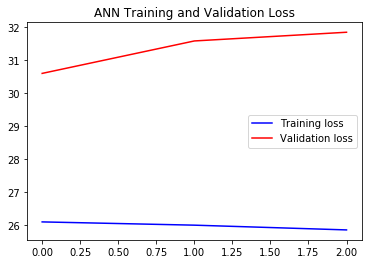


Validation:
MAPE: 31.85354173183441
MSE: 17893.953
CV(RMSE): 75.77049554671142
MBE: -45.367302

Test:
MAPE: 26.37907564640045
MSE: 11914.708
CV(RMSE): 65.88402596034258
MBE: -35.376842

Fold #4


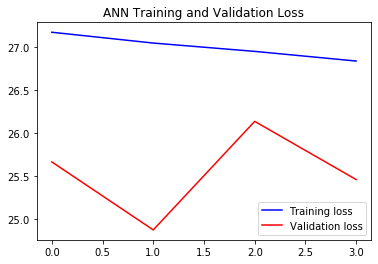


Validation:
MAPE: 25.459811091423035
MSE: 11452.151
CV(RMSE): 64.59247883915994
MBE: -33.870403

Test:
MAPE: 27.40386128425598
MSE: 17060.373
CV(RMSE): 74.22179045682083
MBE: -44.325005

4-Fold Average

Validation:
MAPE: 31.84913918375969
MSE: 16226.74658203125
CV(RMSE): 73.96536799393166
MBE: -41.25063514709473

Test:
MAPE: 28.956346958875656
MSE: 16403.155029296875
CV(RMSE): 74.67424644407008
MBE: -43.38710117340088
-----Experiment #8-----

Fold #1
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


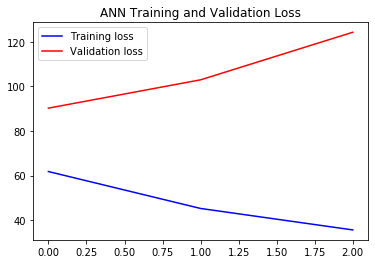


Validation:
MAPE: 124.29977655410767
MSE: 32913.78
CV(RMSE): 104.00260215500911
MBE: -48.55018

Test:
MAPE: 38.45686316490173
MSE: 31669.016
CV(RMSE): 107.70878428835903
MBE: -70.53003

Fold #2


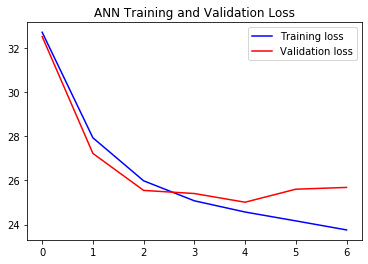


Validation:
MAPE: 25.68209171295166
MSE: 11178.434
CV(RMSE): 63.991799552749896
MBE: -27.6298

Test:
MAPE: 29.428640007972717
MSE: 16025.145
CV(RMSE): 71.70475702267305
MBE: -42.00118

Fold #3


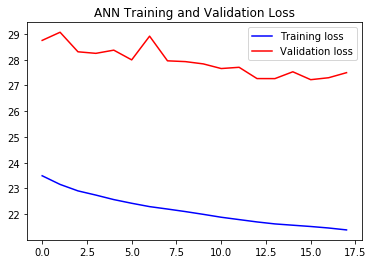


Validation:
MAPE: 27.498242259025574
MSE: 11395.026
CV(RMSE): 60.46508341537749
MBE: -32.025658

Test:
MAPE: 21.926197409629822
MSE: 6441.348
CV(RMSE): 48.44252864670828
MBE: -22.300247

Fold #4


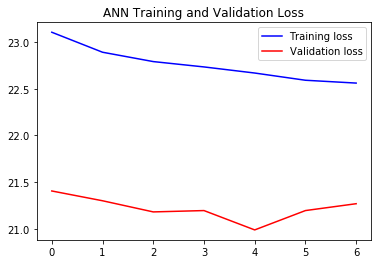


Validation:
MAPE: 21.267622709274292
MSE: 5866.7085
CV(RMSE): 46.231254936546954
MBE: -19.963318

Test:
MAPE: 23.26849400997162
MSE: 9986.135
CV(RMSE): 56.78529598339098
MBE: -29.461452

4-Fold Average

Validation:
MAPE: 49.6869333088398
MSE: 15338.487426757812
CV(RMSE): 68.67268501492087
MBE: -32.04223871231079

Test:
MAPE: 28.270048648118973
MSE: 16030.410766601562
CV(RMSE): 71.16034148528284
MBE: -41.07322692871094
-----Experiment #9-----

Fold #1
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


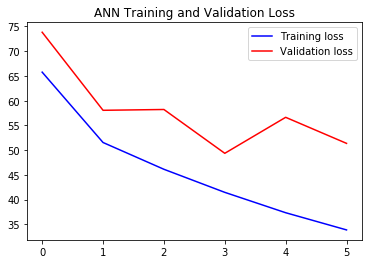


Validation:
MAPE: 51.37098431587219
MSE: 38260.645
CV(RMSE): 112.13249087238235
MBE: -79.381584

Test:
MAPE: 37.04390227794647
MSE: 34525.113
CV(RMSE): 112.46085822740527
MBE: -77.476776

Fold #2


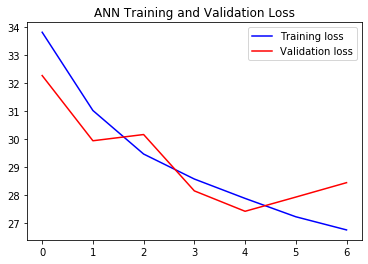


Validation:
MAPE: 28.450560569763184
MSE: 14232.137
CV(RMSE): 72.20527328082353
MBE: -35.386753

Test:
MAPE: 30.987736582756042
MSE: 18911.367
CV(RMSE): 77.89479315840317
MBE: -48.42547

Fold #3


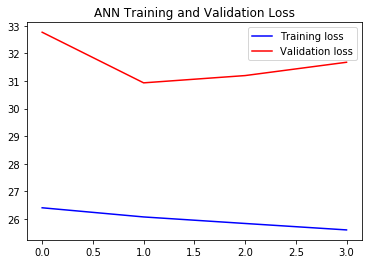


Validation:
MAPE: 31.680339574813843
MSE: 17425.152
CV(RMSE): 74.77135890103267
MBE: -44.423363

Test:
MAPE: 26.018932461738586
MSE: 11586.974
CV(RMSE): 64.97157985712012
MBE: -34.758587

Fold #4


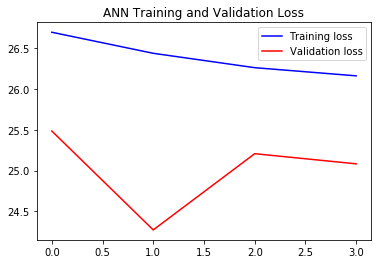


Validation:
MAPE: 25.08293092250824
MSE: 10793.676
CV(RMSE): 62.70802111515859
MBE: -32.30517

Test:
MAPE: 26.45466923713684
MSE: 16283.092
CV(RMSE): 72.51128759772382
MBE: -42.941956

4-Fold Average

Validation:
MAPE: 34.146203845739365
MSE: 20177.90234375
CV(RMSE): 80.4542860423493
MBE: -47.87421703338623

Test:
MAPE: 30.126310139894485
MSE: 20326.636474609375
CV(RMSE): 81.9596297101631
MBE: -50.900696754455566
-----Experiment #10-----

Fold #1
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


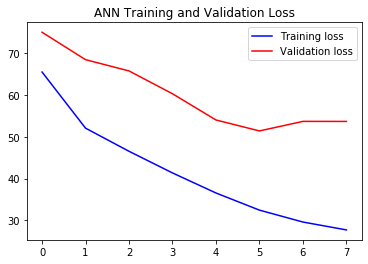


Validation:
MAPE: 53.67896556854248
MSE: 26021.201
CV(RMSE): 92.47386057966965
MBE: -52.222984

Test:
MAPE: 31.596344709396362
MSE: 23619.271
CV(RMSE): 93.01802022285668
MBE: -56.574596

Fold #2


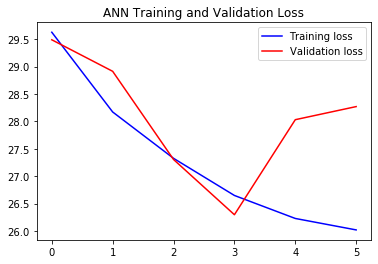


Validation:
MAPE: 28.268727660179138
MSE: 13756.77
CV(RMSE): 70.98916544282729
MBE: -34.534832

Test:
MAPE: 30.73575794696808
MSE: 18584.06
CV(RMSE): 77.21777436434901
MBE: -47.77246

Fold #3


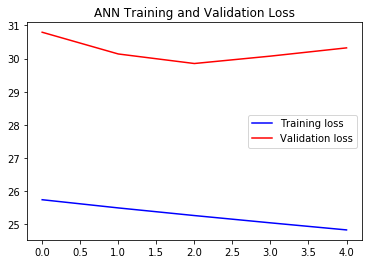


Validation:
MAPE: 30.321502685546875
MSE: 17199.912
CV(RMSE): 74.28653562246257
MBE: -44.264732

Test:
MAPE: 24.35113936662674
MSE: 11243.733
CV(RMSE): 64.00201808986579
MBE: -34.17341

Fold #4


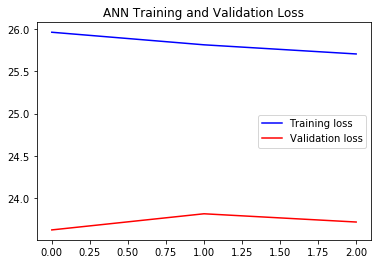


Validation:
MAPE: 23.719407618045807
MSE: 10809.5
CV(RMSE): 62.75396968370733
MBE: -32.605347

Test:
MAPE: 25.456419587135315
MSE: 16453.771
CV(RMSE): 72.8903342856142
MBE: -43.176342

4-Fold Average

Validation:
MAPE: 33.997150883078575
MSE: 16946.845703125
CV(RMSE): 75.12588283216671
MBE: -40.90697383880615

Test:
MAPE: 28.034915402531624
MSE: 17475.209228515625
CV(RMSE): 76.78203674067142
MBE: -45.42420196533203
-----Experiment #11-----

Fold #1
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


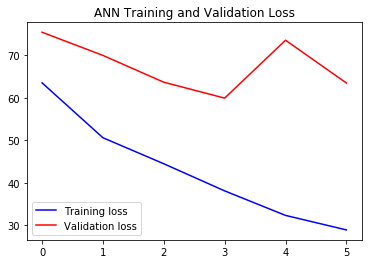


Validation:
MAPE: 63.50128650665283
MSE: 27615.719
CV(RMSE): 95.26502784318106
MBE: -52.70139

Test:
MAPE: 34.57227647304535
MSE: 24474.738
CV(RMSE): 94.68755200663173
MBE: -56.849384

Fold #2


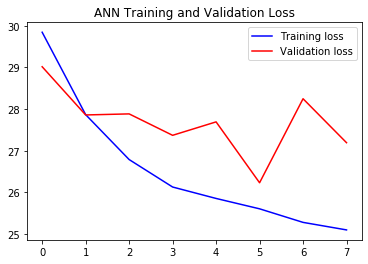


Validation:
MAPE: 27.191844582557678
MSE: 12266.841
CV(RMSE): 67.03478203530014
MBE: -31.639433

Test:
MAPE: 30.085396766662598
MSE: 17135.557
CV(RMSE): 74.1474257235681
MBE: -43.413303

Fold #3


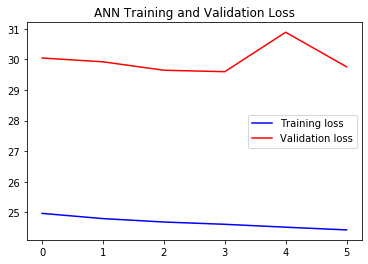


Validation:
MAPE: 29.755455255508423
MSE: 16481.645
CV(RMSE): 72.71889368261283
MBE: -43.379604

Test:
MAPE: 24.849320948123932
MSE: 10363.443
CV(RMSE): 61.44555449211037
MBE: -31.63753

Fold #4


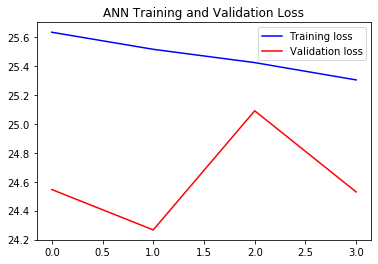


Validation:
MAPE: 24.52915608882904
MSE: 10121.191
CV(RMSE): 60.72314242158995
MBE: -30.892206

Test:
MAPE: 25.666767358779907
MSE: 15808.817
CV(RMSE): 71.44747183129611
MBE: -41.644398

4-Fold Average

Validation:
MAPE: 36.24443560838699
MSE: 16621.348876953125
CV(RMSE): 73.93546149567099
MBE: -39.65315818786621

Test:
MAPE: 28.793440386652946
MSE: 16945.638916015625
CV(RMSE): 75.43200101340159
MBE: -43.38615369796753
-----Experiment #12-----

Fold #1
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


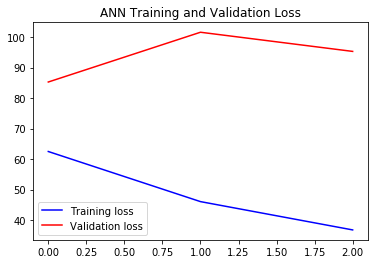


Validation:
MAPE: 95.33290266990662
MSE: 34564.477
CV(RMSE): 106.57867263327712
MBE: -58.46702

Test:
MAPE: 39.38300609588623
MSE: 33160.33
CV(RMSE): 110.21564939463126
MBE: -73.993324

Fold #2


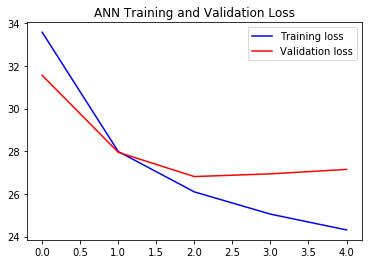


Validation:
MAPE: 27.148452401161194
MSE: 12391.95
CV(RMSE): 67.37576083220216
MBE: -29.935614

Test:
MAPE: 29.895606637001038
MSE: 17424.24
CV(RMSE): 74.76940557160427
MBE: -45.600048

Fold #3


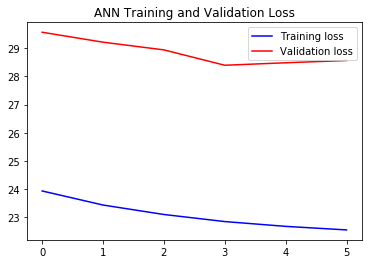


Validation:
MAPE: 28.561976552009583
MSE: 13334.515
CV(RMSE): 65.40870955019923
MBE: -36.029644

Test:
MAPE: 22.896669805049896
MSE: 7999.6523
CV(RMSE): 53.98510581156832
MBE: -25.30181

Fold #4


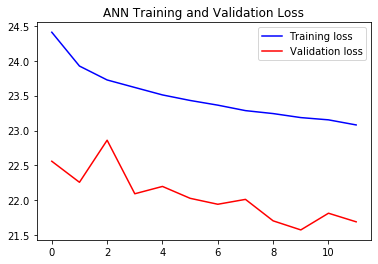


Validation:
MAPE: 21.691785752773285
MSE: 6838.226
CV(RMSE): 49.91259272603491
MBE: -21.557447

Test:
MAPE: 23.449137806892395
MSE: 11346.231
CV(RMSE): 60.52893207776078
MBE: -32.363953

4-Fold Average

Validation:
MAPE: 43.18377934396267
MSE: 16782.291870117188
CV(RMSE): 72.31893393542835
MBE: -36.4974308013916

Test:
MAPE: 28.90610508620739
MSE: 17482.613037109375
CV(RMSE): 74.87477321389115
MBE: -44.314783573150635
-----Experiment #13-----

Fold #1
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


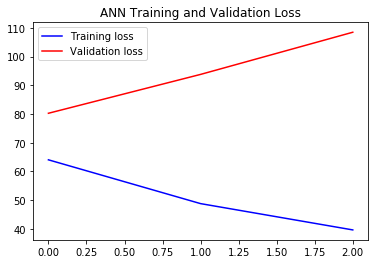


Validation:
MAPE: 108.45383405685425
MSE: 39755.484
CV(RMSE): 114.30200305929034
MBE: -69.133934

Test:
MAPE: 41.82913601398468
MSE: 38297.59
CV(RMSE): 118.44576986253902
MBE: -84.610855

Fold #2


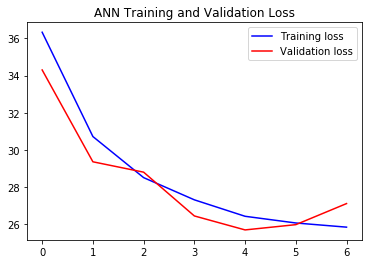


Validation:
MAPE: 27.118369936943054
MSE: 13236.363
CV(RMSE): 69.63349281571962
MBE: -33.117203

Test:
MAPE: 30.147793889045715
MSE: 18412.508
CV(RMSE): 76.86054844131658
MBE: -46.637512

Fold #3


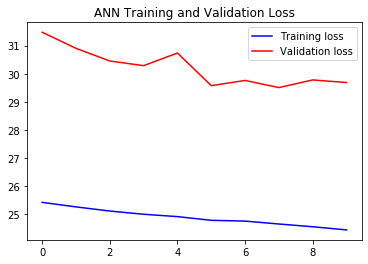


Validation:
MAPE: 29.68771755695343
MSE: 16902.014
CV(RMSE): 73.64041573418955
MBE: -44.40336

Test:
MAPE: 23.992399871349335
MSE: 10410.058
CV(RMSE): 61.58358900225755
MBE: -32.16735

Fold #4


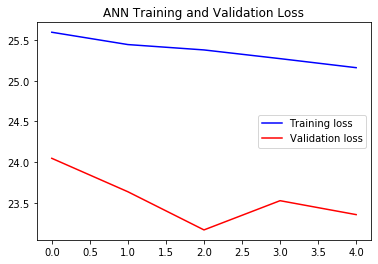


Validation:
MAPE: 23.356124758720398
MSE: 10000.987
CV(RMSE): 60.36147588754693
MBE: -30.4909

Test:
MAPE: 25.363707542419434
MSE: 15852.846
CV(RMSE): 71.54689512158663
MBE: -42.28288

4-Fold Average

Validation:
MAPE: 47.15401157736778
MSE: 19973.712158203125
CV(RMSE): 79.48434687418661
MBE: -44.286348819732666

Test:
MAPE: 30.33325932919979
MSE: 20743.250244140625
CV(RMSE): 82.10920060692496
MBE: -51.424649238586426
-----Experiment #14-----

Fold #1
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_89 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


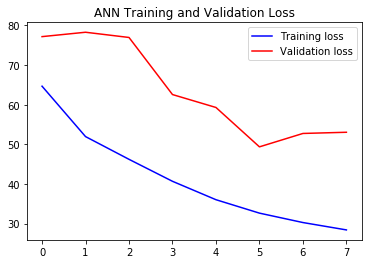


Validation:
MAPE: 53.04532051086426
MSE: 25915.629
CV(RMSE): 92.2860816984651
MBE: -52.09335

Test:
MAPE: 32.18124508857727
MSE: 23177.914
CV(RMSE): 92.1448444608054
MBE: -55.911755

Fold #2


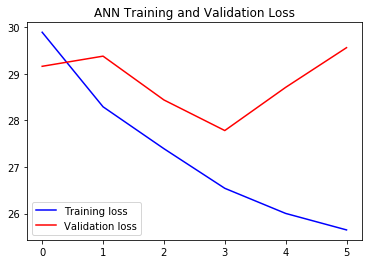


Validation:
MAPE: 29.56261932849884
MSE: 13402.477
CV(RMSE): 70.06907404229759
MBE: -33.757713

Test:
MAPE: 30.417758226394653
MSE: 18225.975
CV(RMSE): 76.47022827765869
MBE: -46.18384

Fold #3


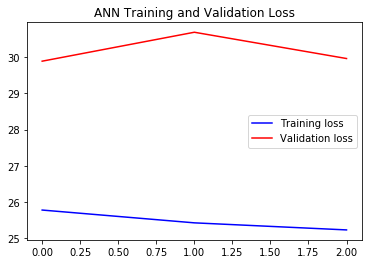


Validation:
MAPE: 29.95782494544983
MSE: 17418.705
CV(RMSE): 74.75752137707305
MBE: -44.638836

Test:
MAPE: 25.04003643989563
MSE: 11404.395
CV(RMSE): 64.45765861051676
MBE: -34.98046

Fold #4


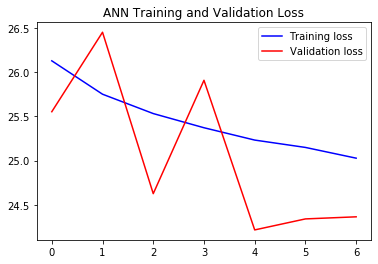


Validation:
MAPE: 24.364130198955536
MSE: 10282.666
CV(RMSE): 61.20561620631524
MBE: -31.203793

Test:
MAPE: 25.091439485549927
MSE: 15828.647
CV(RMSE): 71.49226932218573
MBE: -41.809654

4-Fold Average

Validation:
MAPE: 34.232473745942116
MSE: 16754.869140625
CV(RMSE): 74.57957333103775
MBE: -40.42342281341553

Test:
MAPE: 28.18261981010437
MSE: 17159.232666015625
CV(RMSE): 76.14125016779165
MBE: -44.72142791748047
-----Experiment #15-----

Fold #1
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


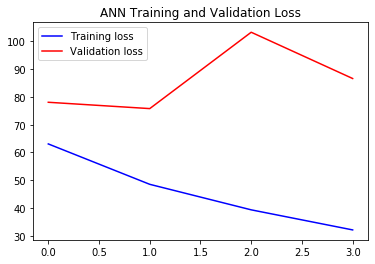


Validation:
MAPE: 86.60165071487427
MSE: 29327.309
CV(RMSE): 98.1728582146547
MBE: -49.982212

Test:
MAPE: 36.28588020801544
MSE: 27007.336
CV(RMSE): 99.46601137464114
MBE: -61.376564

Fold #2


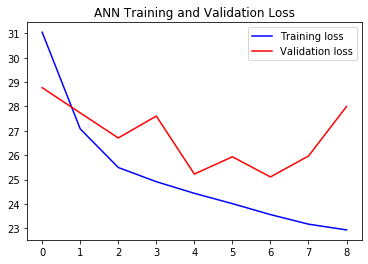


Validation:
MAPE: 27.998802065849304
MSE: 10183.119
CV(RMSE): 61.07651903694385
MBE: -23.744135

Test:
MAPE: 27.970868349075317
MSE: 14886.042
CV(RMSE): 69.10931808146057
MBE: -40.135494

Fold #3


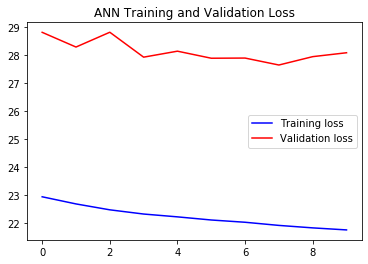


Validation:
MAPE: 28.0891090631485
MSE: 11829.339
CV(RMSE): 61.60659703306546
MBE: -30.492306

Test:
MAPE: 21.899352967739105
MSE: 6993.3716
CV(RMSE): 50.47562616782491
MBE: -24.117485

Fold #4


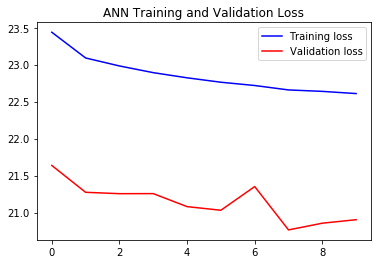


Validation:
MAPE: 20.90306133031845
MSE: 6123.6934
CV(RMSE): 47.23295491385357
MBE: -20.681082

Test:
MAPE: 22.591929137706757
MSE: 10371.765
CV(RMSE): 57.87133491233686
MBE: -30.656944

4-Fold Average

Validation:
MAPE: 40.89815579354763
MSE: 14365.864990234375
CV(RMSE): 67.0222322996294
MBE: -31.224933624267578

Test:
MAPE: 27.187007665634155
MSE: 14814.628540039062
CV(RMSE): 69.23057263406588
MBE: -39.071621894836426
-----Experiment #16-----

Fold #1
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


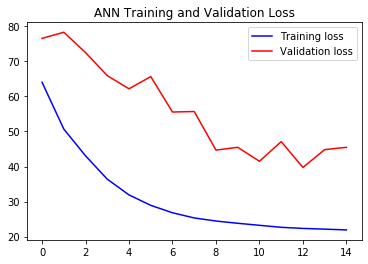


Validation:
MAPE: 45.468008518218994
MSE: 14188.947
CV(RMSE): 68.28580283366178
MBE: -26.613585

Test:
MAPE: 27.706709504127502
MSE: 11330.645
CV(RMSE): 64.42600009272303
MBE: -29.850506

Fold #2


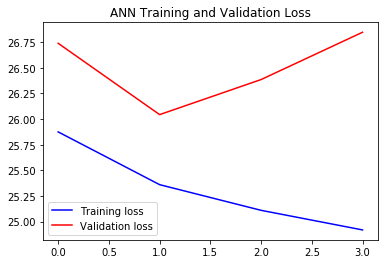


Validation:
MAPE: 26.847034692764282
MSE: 11943.128
CV(RMSE): 66.14437308793376
MBE: -31.061525

Test:
MAPE: 30.347126722335815
MSE: 16468.848
CV(RMSE): 72.69065683640667
MBE: -42.259686

Fold #3


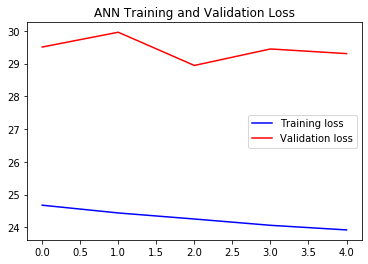


Validation:
MAPE: 29.307496547698975
MSE: 15834.636
CV(RMSE): 71.27726309852153
MBE: -41.377106

Test:
MAPE: 23.918718099594116
MSE: 10140.914
CV(RMSE): 60.78227507029053
MBE: -31.315277

Fold #4


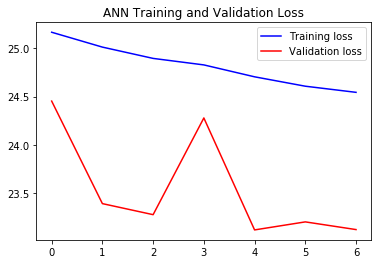


Validation:
MAPE: 23.119117319583893
MSE: 9617.323
CV(RMSE): 59.19234315779857
MBE: -28.869764

Test:
MAPE: 25.32951533794403
MSE: 14984.981
CV(RMSE): 69.56091782441568
MBE: -40.165592

4-Fold Average

Validation:
MAPE: 31.185414269566536
MSE: 12896.008544921875
CV(RMSE): 66.22494554447891
MBE: -31.9804949760437

Test:
MAPE: 26.825517416000366
MSE: 13231.346923828125
CV(RMSE): 66.86496245595897
MBE: -35.897765159606934
-----Experiment #17-----

Fold #1
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


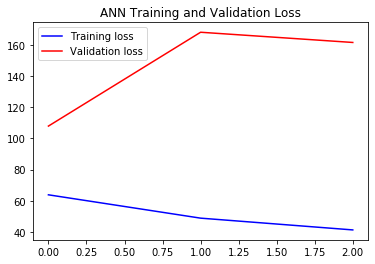


Validation:
MAPE: 161.71997785568237
MSE: 39498.816
CV(RMSE): 113.93242846894738
MBE: -60.24599

Test:
MAPE: 43.807342648506165
MSE: 38625.875
CV(RMSE): 118.95234793376325
MBE: -85.42677

Fold #2


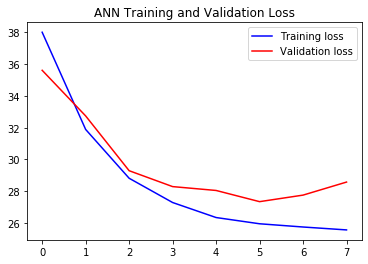


Validation:
MAPE: 28.578922152519226
MSE: 13420.826
CV(RMSE): 70.1170240413094
MBE: -33.489895

Test:
MAPE: 30.517354607582092
MSE: 18654.389
CV(RMSE): 77.36374684539459
MBE: -47.775154

Fold #3


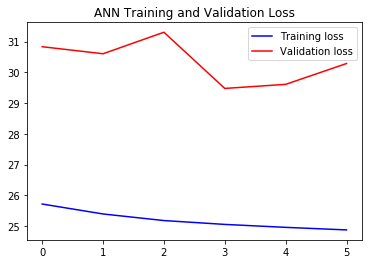


Validation:
MAPE: 30.28685748577118
MSE: 17145.17
CV(RMSE): 74.16822090323508
MBE: -45.313976

Test:
MAPE: 25.728869438171387
MSE: 10731.924
CV(RMSE): 62.52838514497238
MBE: -33.32424

Fold #4


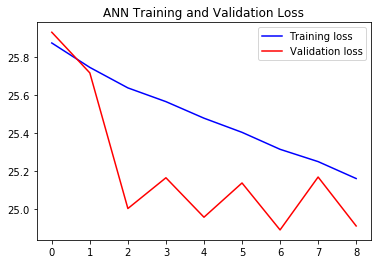


Validation:
MAPE: 24.910835921764374
MSE: 10095.709
CV(RMSE): 60.64664896877745
MBE: -30.693777

Test:
MAPE: 26.393327116966248
MSE: 16032.357
CV(RMSE): 71.95083990201346
MBE: -42.035645

4-Fold Average

Validation:
MAPE: 61.37414835393429
MSE: 20040.13037109375
CV(RMSE): 79.71608059556733
MBE: -42.43590974807739

Test:
MAPE: 31.611723452806473
MSE: 21011.13623046875
CV(RMSE): 82.69882995653592
MBE: -52.14045333862305
-----Experiment #18-----

Fold #1
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_96 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


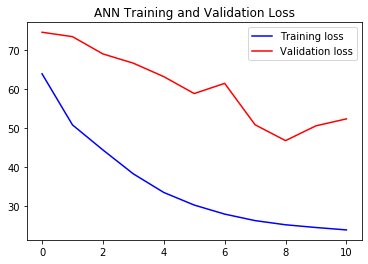


Validation:
MAPE: 52.426958084106445
MSE: 17129.307
CV(RMSE): 75.02832165987888
MBE: -35.832638

Test:
MAPE: 29.41471040248871
MSE: 14346.487
CV(RMSE): 72.49476493510403
MBE: -38.45219

Fold #2


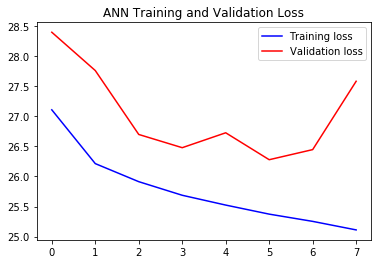


Validation:
MAPE: 27.58464217185974
MSE: 12619.242
CV(RMSE): 67.99085440581251
MBE: -32.242954

Test:
MAPE: 31.20180070400238
MSE: 17133.852
CV(RMSE): 74.14373514097551
MBE: -43.62638

Fold #3


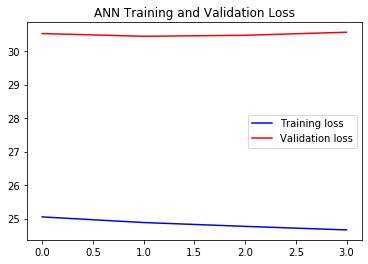


Validation:
MAPE: 30.565357208251953
MSE: 16744.486
CV(RMSE): 73.29643960767811
MBE: -43.47363

Test:
MAPE: 24.431385099887848
MSE: 10932.612
CV(RMSE): 63.11032206179673
MBE: -33.311005

Fold #4


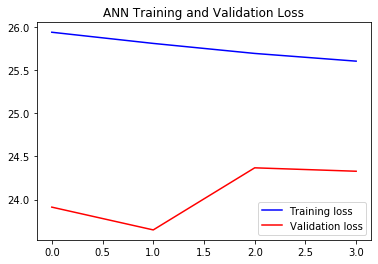


Validation:
MAPE: 24.32791143655777
MSE: 10539.99
CV(RMSE): 61.96671938456732
MBE: -31.471796

Test:
MAPE: 26.911526918411255
MSE: 16077.539
CV(RMSE): 72.05215341837848
MBE: -42.175938

4-Fold Average

Validation:
MAPE: 33.72621722519398
MSE: 14258.25634765625
CV(RMSE): 69.57058376448421
MBE: -35.75525426864624

Test:
MAPE: 27.989855781197548
MSE: 14622.62255859375
CV(RMSE): 70.45024388906369
MBE: -39.39137840270996
-----Experiment #19-----

Fold #1
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 8)                 1968      
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


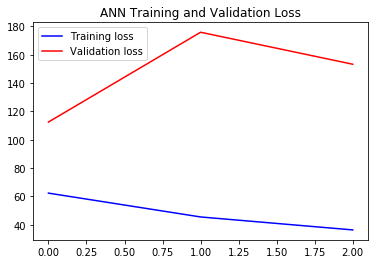


Validation:
MAPE: 153.24163436889648
MSE: 32427.457
CV(RMSE): 103.23138527140726
MBE: -41.34734

Test:
MAPE: 39.3192857503891
MSE: 31227.633
CV(RMSE): 106.95556664209445
MBE: -70.50521

Fold #2


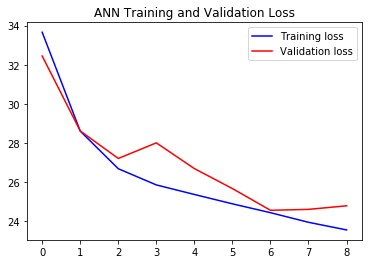


Validation:
MAPE: 24.787059426307678
MSE: 10532.512
CV(RMSE): 62.11547878055543
MBE: -25.633139

Test:
MAPE: 28.829872608184814
MSE: 15161.446
CV(RMSE): 69.74567996564214
MBE: -40.6927

Fold #3


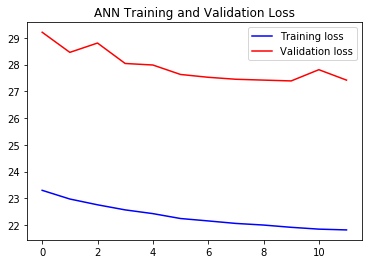


Validation:
MAPE: 27.420300245285034
MSE: 11810.16
CV(RMSE): 61.55663587925624
MBE: -32.581818

Test:
MAPE: 22.279970347881317
MSE: 6815.5537
CV(RMSE): 49.829781229922254
MBE: -22.544533

Fold #4


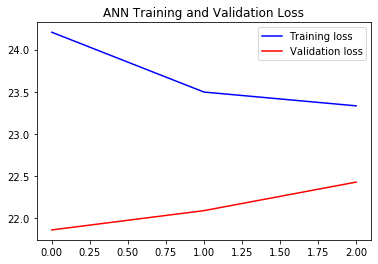


Validation:
MAPE: 22.42865115404129
MSE: 7109.0884
CV(RMSE): 50.891511828555934
MBE: -24.14266

Test:
MAPE: 23.610691726207733
MSE: 11591.832
CV(RMSE): 61.180526821614336
MBE: -32.86334

4-Fold Average

Validation:
MAPE: 56.96941129863262
MSE: 15469.804321289062
CV(RMSE): 69.44875293994372
MBE: -30.926239013671875

Test:
MAPE: 28.50995510816574
MSE: 16199.1162109375
CV(RMSE): 71.9278886648183
MBE: -41.651445388793945
-----Experiment #20-----

Fold #1
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 8)                 1968      
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 9         
Total params: 1,977
Trainable params: 1,977
Non-trainable params: 0
_________________________________________________________________


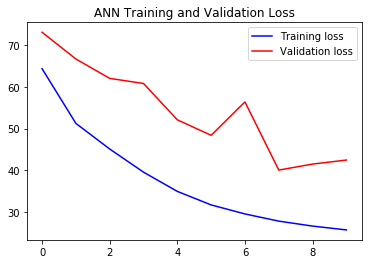


Validation:
MAPE: 42.486271262168884
MSE: 21382.105
CV(RMSE): 83.82634875262671
MBE: -48.538754

Test:
MAPE: 31.20741844177246
MSE: 18020.303
CV(RMSE): 81.24841036333207
MBE: -46.953312

Fold #2


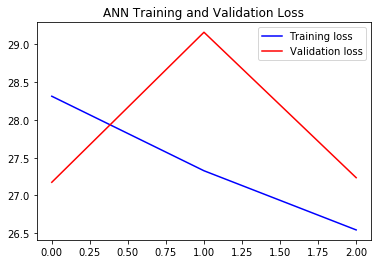


Validation:
MAPE: 27.235722541809082
MSE: 13363.471
CV(RMSE): 69.96703714628795
MBE: -34.884064

Test:
MAPE: 31.21473789215088
MSE: 18104.334
CV(RMSE): 76.21461870015607
MBE: -46.595802

Fold #3


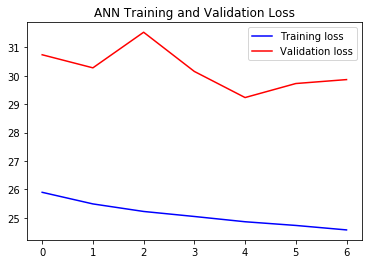


Validation:
MAPE: 29.863369464874268
MSE: 16495.975
CV(RMSE): 72.75050131854059
MBE: -43.45913

Test:
MAPE: 25.056642293930054
MSE: 10529.052
CV(RMSE): 61.9345581495759
MBE: -31.673737

Fold #4


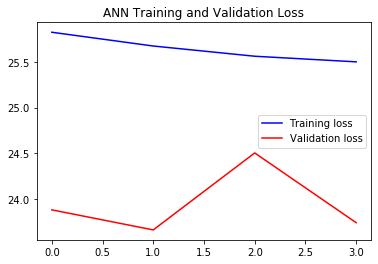


Validation:
MAPE: 23.73800128698349
MSE: 10012.678
CV(RMSE): 60.39674548932232
MBE: -30.34751

Test:
MAPE: 25.149673223495483
MSE: 15547.308
CV(RMSE): 70.85406656994721
MBE: -41.70864

4-Fold Average

Validation:
MAPE: 30.83084113895893
MSE: 15313.55712890625
CV(RMSE): 71.7351581766944
MBE: -39.307363986968994

Test:
MAPE: 28.15711796283722
MSE: 15550.2490234375
CV(RMSE): 72.56291344575281
MBE: -41.73287296295166

Overall Validation:
MAPE: 42.508930284529924
MSE: 16936.378216552734
CV(RMSE): 73.55031107490458
MBE: -38.45889544487

Overall Test:
MAPE: 28.9534717425704
MSE: 17477.079827880858
CV(RMSE): 75.55369105936315
MBE: -44.692313885688776


In [122]:
ann_model = None

n_features = train_folds[0][0].shape[-1]

# utils.walk_forward_cv(
#     ann_model, 
#     train_folds, 
#     val_folds, 
#     test_folds, 
#     callbacks=callbacks, 
#     verbose=verbose, 
#     model_name="ANN"
# )

metrics = np.zeros((2,4))

for i in range(N):
    ann_model = Sequential()
    ann_model.add(Dense(8, activation='relu', input_shape = [n_features]))
    ann_model.add(Dense(1))
    print("-----Experiment #" + str(i + 1) + "-----")
    metrics = metrics + utils.walk_forward_cv(
        ann_model, 
        train_folds, 
        val_folds, 
        test_folds, 
        callbacks=callbacks, 
        verbose=verbose, 
        model_name="ANN"
    ) / N

print("\nOverall Validation:")
utils.print_metrics(*metrics[0])
print("\nOverall Test:")
utils.print_metrics(*metrics[1])

# Overall Validation:
# MAPE: 38.00202697515488
# MSE: 43097.4432800293
# CV(RMSE): 117.60132177260635
# MBE: -69.48708001375198

# Overall Test:
# MAPE: 40.03982916474342
# MSE: 42431.93391723634
# CV(RMSE): 117.8805092994159
# MBE: -70.02141468524933

#### Reshaping for Models with 3D Input



In [123]:
for idx, fold in enumerate(train_folds):
    train_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(train_folds[idx][0][:, :-num_targets], timesteps, df_name="Train"),
                np.repeat(train_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        train_folds[idx][1]
    )
    val_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(val_folds[idx][0][:, :-num_targets], timesteps, df_name="Val"),
                np.repeat(val_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        val_folds[idx][1]
    )
    test_folds[idx] = (
        np.dstack(
            [
                utils.reshape_for_lstm(test_folds[idx][0][:, :-num_targets], timesteps, df_name="Test"),
                np.repeat(test_folds[idx][0][:, -num_targets:][:, np.newaxis, :], timesteps, axis=1)
            ]
        ),
        test_folds[idx][1]
    )

n_features = train_folds[0][0].shape[-1]

Train: (125257, 24, 9)
Val: (127345, 24, 9)
Test: (125257, 24, 9)
Train: (253321, 24, 9)
Val: (125257, 24, 9)
Test: (127345, 24, 9)
Train: (379297, 24, 9)
Val: (127345, 24, 9)
Test: (125257, 24, 9)
Train: (507361, 24, 9)
Val: (125257, 24, 9)
Test: (127345, 24, 9)


### Vanilla LSTM

-----Experiment #1-----

Fold #1
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_102 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable params: 0
_________________________________________________________________


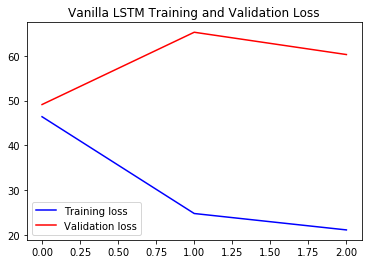


Validation:
MAPE: 60.28510928153992
MSE: 19090.936
CV(RMSE): 79.20797847247692
MBE: -25.880577

Test:
MAPE: 27.436330914497375
MSE: 14494.553
CV(RMSE): 72.86790126215998
MBE: -32.59297

Fold #2


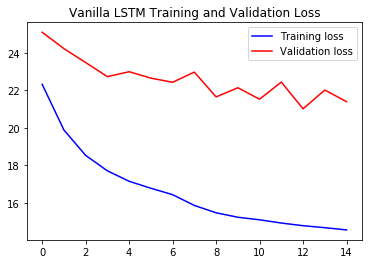


Validation:
MAPE: 21.40226513147354
MSE: 3805.4336
CV(RMSE): 37.33670033079219
MBE: -3.9842563

Test:
MAPE: 22.773168981075287
MSE: 5764.605
CV(RMSE): 43.00626819956354
MBE: -15.221349

Fold #3


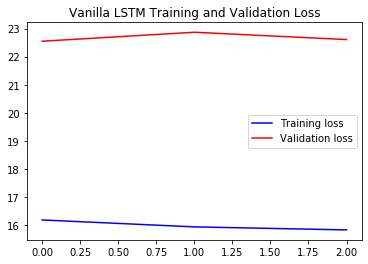


Validation:
MAPE: 22.606848180294037
MSE: 6427.2183
CV(RMSE): 45.410734616947344
MBE: -18.120365

Test:
MAPE: 19.186845421791077
MSE: 2677.282
CV(RMSE): 31.23096988780039
MBE: -10.579436

Fold #4


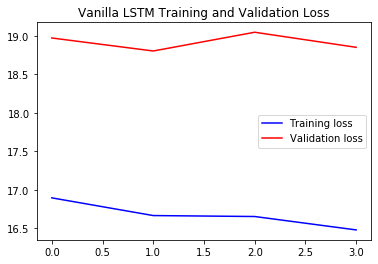


Validation:
MAPE: 18.85093003511429
MSE: 2364.3335
CV(RMSE): 29.348964319817508
MBE: -7.176156

Test:
MAPE: 19.882668554782867
MSE: 4989.7676
CV(RMSE): 40.1399998543312
MBE: -13.164126

4-Fold Average

Validation:
MAPE: 30.786288157105446
MSE: 7921.980224609375
CV(RMSE): 47.826094435008486
MBE: -13.790338635444641

Test:
MAPE: 22.31975346803665
MSE: 6981.551818847656
CV(RMSE): 46.811284800963776
MBE: -17.88947081565857
-----Experiment #2-----

Fold #1
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_104 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable 

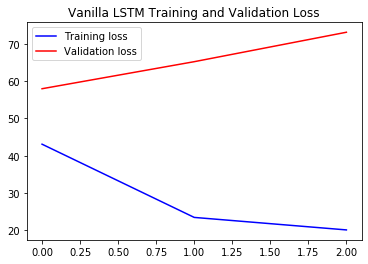


Validation:
MAPE: 73.15658330917358
MSE: 13837.464
CV(RMSE): 67.43472284923553
MBE: -1.7389289

Test:
MAPE: 25.84320306777954
MSE: 9458.203
CV(RMSE): 58.86242875610942
MBE: -20.853302

Fold #2


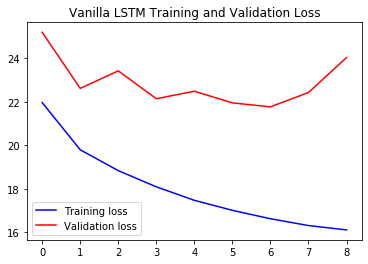


Validation:
MAPE: 24.028688669204712
MSE: 4873.518
CV(RMSE): 42.25276428234866
MBE: -4.3028736

Test:
MAPE: 24.02113527059555
MSE: 7154.009
CV(RMSE): 47.909509680605574
MBE: -16.209026

Fold #3


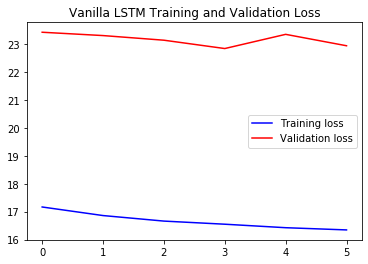


Validation:
MAPE: 22.94587343931198
MSE: 7248.403
CV(RMSE): 48.22454455228955
MBE: -18.962936

Test:
MAPE: 19.206085801124573
MSE: 3400.721
CV(RMSE): 35.198480040877556
MBE: -10.689342

Fold #4


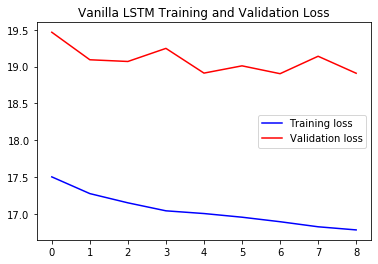


Validation:
MAPE: 18.909069895744324
MSE: 3105.8694
CV(RMSE): 33.637987815570604
MBE: -8.33063

Test:
MAPE: 20.17679661512375
MSE: 5702.325
CV(RMSE): 42.91045999085061
MBE: -14.612756

4-Fold Average

Validation:
MAPE: 34.76005382835865
MSE: 7266.313537597656
CV(RMSE): 47.88750487486109
MBE: -8.333842307329178

Test:
MAPE: 22.311805188655853
MSE: 6428.814514160156
CV(RMSE): 46.220219617110786
MBE: -15.591106414794922
-----Experiment #3-----

Fold #1
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_106 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable pa

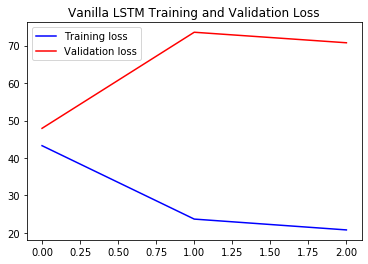


Validation:
MAPE: 70.75912952423096
MSE: 14866.558
CV(RMSE): 69.89732299410876
MBE: -11.510463

Test:
MAPE: 26.51248574256897
MSE: 11228.174
CV(RMSE): 64.13401489072812
MBE: -24.460674

Fold #2


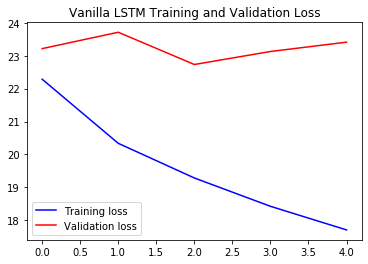


Validation:
MAPE: 23.41074049472809
MSE: 5657.4927
CV(RMSE): 45.52457132682413
MBE: -14.595464

Test:
MAPE: 24.59973245859146
MSE: 9170.004
CV(RMSE): 54.241507921917645
MBE: -25.251799

Fold #3


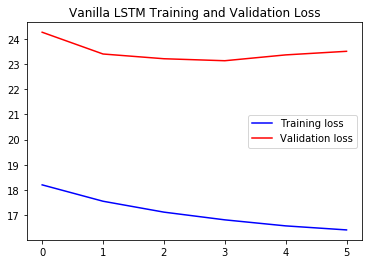


Validation:
MAPE: 23.506566882133484
MSE: 8445.0
CV(RMSE): 52.05312641178829
MBE: -18.975786

Test:
MAPE: 19.742092490196228
MSE: 3899.7537
CV(RMSE): 37.69267959820929
MBE: -14.109723

Fold #4


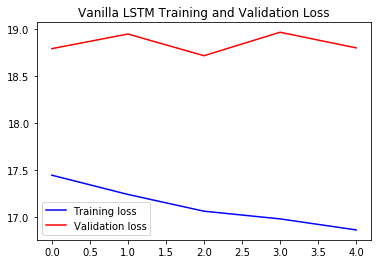


Validation:
MAPE: 18.800169229507446
MSE: 2898.6104
CV(RMSE): 32.496257065893325
MBE: -11.313417

Test:
MAPE: 19.93064135313034
MSE: 5691.153
CV(RMSE): 42.868402460692835
MBE: -17.03101

4-Fold Average

Validation:
MAPE: 34.119151532649994
MSE: 7966.9151611328125
CV(RMSE): 49.99281944965363
MBE: -14.098782539367676

Test:
MAPE: 22.69623801112175
MSE: 7497.271057128906
CV(RMSE): 49.734151217886975
MBE: -20.213301420211792
-----Experiment #4-----

Fold #1
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_108 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainabl

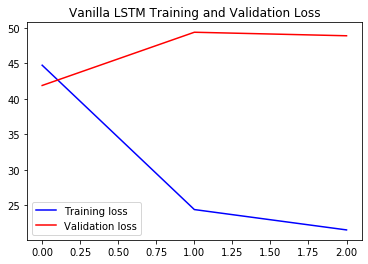


Validation:
MAPE: 48.907044529914856
MSE: 18187.61
CV(RMSE): 77.3113304221644
MBE: -24.235466

Test:
MAPE: 27.535679936408997
MSE: 13924.591
CV(RMSE): 71.42085858204317
MBE: -30.801504

Fold #2


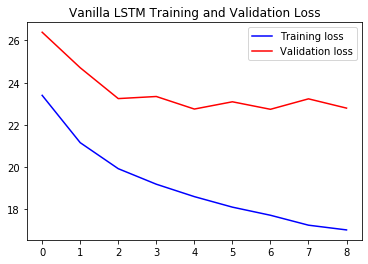


Validation:
MAPE: 22.796131670475006
MSE: 4325.5674
CV(RMSE): 39.80662629828409
MBE: -10.300295

Test:
MAPE: 24.134977161884308
MSE: 6652.1562
CV(RMSE): 46.19853571165884
MBE: -19.913923

Fold #3


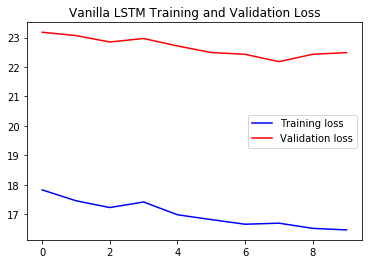


Validation:
MAPE: 22.485928237438202
MSE: 5775.0723
CV(RMSE): 43.04529589440405
MBE: -15.3975315

Test:
MAPE: 19.379401206970215
MSE: 2530.0916
CV(RMSE): 30.360332469069217
MBE: -9.271819

Fold #4


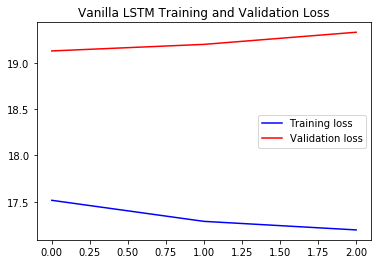


Validation:
MAPE: 19.329658150672913
MSE: 2385.6453
CV(RMSE): 29.480940968476833
MBE: -5.887756

Test:
MAPE: 20.308904349803925
MSE: 4793.081
CV(RMSE): 39.34092412285707
MBE: -14.282549

4-Fold Average

Validation:
MAPE: 28.379690647125244
MSE: 7668.473571777344
CV(RMSE): 47.41104839583234
MBE: -13.955262064933777

Test:
MAPE: 22.83974066376686
MSE: 6974.979919433594
CV(RMSE): 46.83016272140708
MBE: -18.56744885444641
-----Experiment #5-----

Fold #1
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_110 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable p

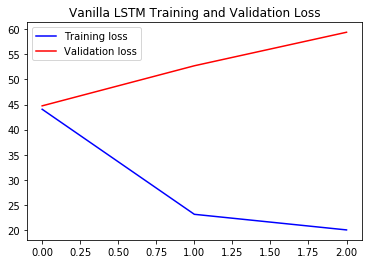


Validation:
MAPE: 59.38236713409424
MSE: 13693.821
CV(RMSE): 67.08379756129756
MBE: -6.5671964

Test:
MAPE: 25.23973286151886
MSE: 9778.88
CV(RMSE): 59.8519654604853
MBE: -21.988811

Fold #2


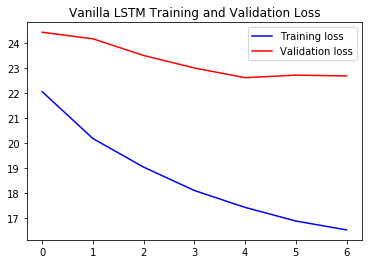


Validation:
MAPE: 22.68361747264862
MSE: 4828.7583
CV(RMSE): 42.058286031348885
MBE: -7.67873

Test:
MAPE: 24.60651993751526
MSE: 7281.114
CV(RMSE): 48.333239556234666
MBE: -19.00663

Fold #3


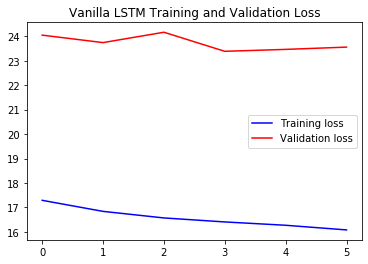


Validation:
MAPE: 23.553821444511414
MSE: 6190.059
CV(RMSE): 44.56504669105563
MBE: -14.77334

Test:
MAPE: 19.246239960193634
MSE: 2786.1228
CV(RMSE): 31.85947013904853
MBE: -8.32893

Fold #4


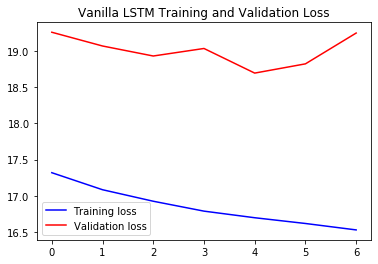


Validation:
MAPE: 19.24823522567749
MSE: 2514.0928
CV(RMSE): 30.264189533194227
MBE: -12.273382

Test:
MAPE: 19.901061058044434
MSE: 4836.442
CV(RMSE): 39.51847531243356
MBE: -16.243568

4-Fold Average

Validation:
MAPE: 31.21701031923294
MSE: 6806.682861328125
CV(RMSE): 45.99282995422408
MBE: -10.323162198066711

Test:
MAPE: 22.248388454318047
MSE: 6170.639587402344
CV(RMSE): 44.89078761705052
MBE: -16.391984939575195
-----Experiment #6-----

Fold #1
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_112 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable 

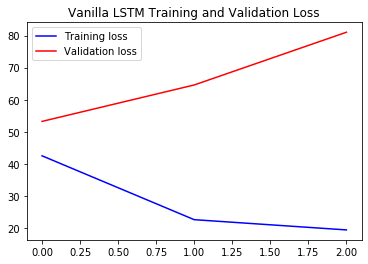


Validation:
MAPE: 81.0581386089325
MSE: 13592.046
CV(RMSE): 66.83404386417395
MBE: -3.7438436

Test:
MAPE: 24.69136118888855
MSE: 9936.98
CV(RMSE): 60.333852791655964
MBE: -22.404955

Fold #2


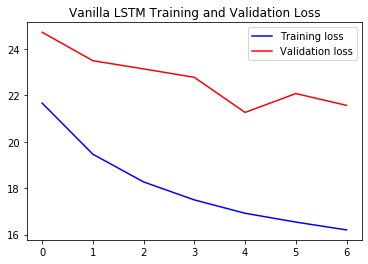


Validation:
MAPE: 21.56524807214737
MSE: 6003.8267
CV(RMSE): 46.89731090273261
MBE: -9.984756

Test:
MAPE: 23.6534982919693
MSE: 8913.015
CV(RMSE): 53.476044791399545
MBE: -21.65641

Fold #3


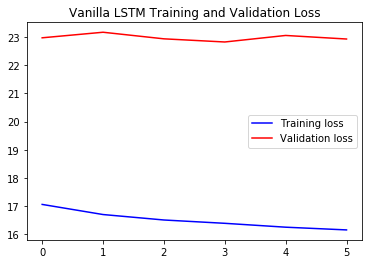


Validation:
MAPE: 22.930580377578735
MSE: 8596.196
CV(RMSE): 52.517029186458174
MBE: -21.511229

Test:
MAPE: 19.704167544841766
MSE: 4320.564
CV(RMSE): 39.67424039804778
MBE: -14.371067

Fold #4


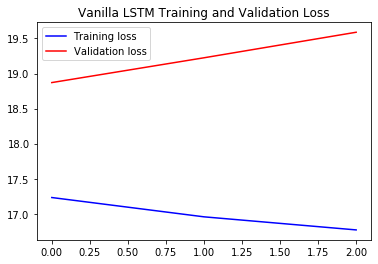


Validation:
MAPE: 19.58816945552826
MSE: 4294.981
CV(RMSE): 39.55660598397906
MBE: -15.122357

Test:
MAPE: 20.80584615468979
MSE: 7767.164
CV(RMSE): 50.080473340355496
MBE: -21.523785

4-Fold Average

Validation:
MAPE: 36.285534128546715
MSE: 8121.762451171875
CV(RMSE): 51.45124748433595
MBE: -12.590546488761902

Test:
MAPE: 22.21371829509735
MSE: 7734.4307861328125
CV(RMSE): 50.891152830364696
MBE: -19.989054203033447
-----Experiment #7-----

Fold #1
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_114 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_115 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable 

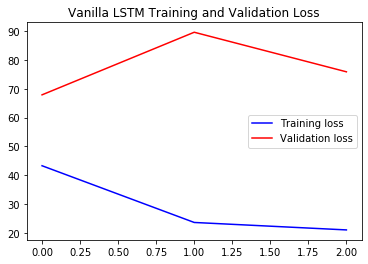


Validation:
MAPE: 75.89738965034485
MSE: 15064.7705
CV(RMSE): 70.36174048376046
MBE: -9.312468

Test:
MAPE: 26.324227452278137
MSE: 11678.39
CV(RMSE): 65.40716494153185
MBE: -26.004307

Fold #2


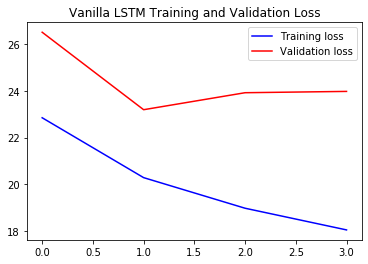


Validation:
MAPE: 23.968912661075592
MSE: 6261.969
CV(RMSE): 47.894905460370786
MBE: -12.409874

Test:
MAPE: 24.472104012966156
MSE: 9791.514
CV(RMSE): 56.04952174111833
MBE: -23.072283

Fold #3


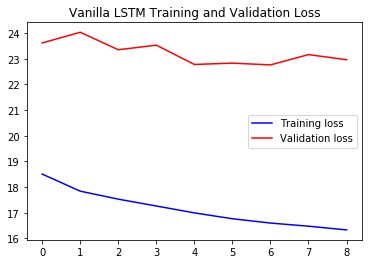


Validation:
MAPE: 22.96404540538788
MSE: 6672.062
CV(RMSE): 46.26760665027426
MBE: -17.241135

Test:
MAPE: 19.526086747646332
MSE: 3081.8987
CV(RMSE): 33.50792914434169
MBE: -9.522595

Fold #4


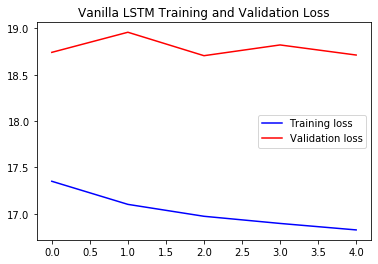


Validation:
MAPE: 18.711963295936584
MSE: 2777.5227
CV(RMSE): 31.810261239117494
MBE: -8.673736

Test:
MAPE: 20.890314877033234
MSE: 5576.686
CV(RMSE): 42.435107151540294
MBE: -16.93886

4-Fold Average

Validation:
MAPE: 35.385577753186226
MSE: 7694.081115722656
CV(RMSE): 49.083628458380744
MBE: -11.909302949905396

Test:
MAPE: 22.803183272480965
MSE: 7532.122009277344
CV(RMSE): 49.34993074463304
MBE: -18.8845112323761
-----Experiment #8-----

Fold #1
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_116 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_117 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable 

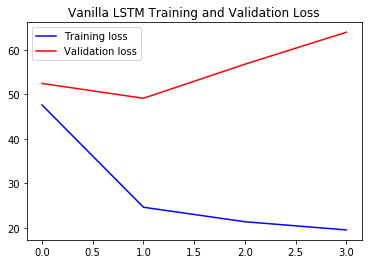


Validation:
MAPE: 63.93726468086243
MSE: 13822.649
CV(RMSE): 67.39861388097668
MBE: -12.74342

Test:
MAPE: 25.725212693214417
MSE: 10570.148
CV(RMSE): 62.2263585355893
MBE: -22.613928

Fold #2


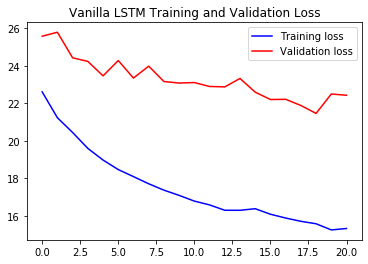


Validation:
MAPE: 22.42121398448944
MSE: 4710.98
CV(RMSE): 41.542200155043254
MBE: -6.6654096

Test:
MAPE: 23.497021198272705
MSE: 7462.072
CV(RMSE): 48.93016752219903
MBE: -16.514746

Fold #3


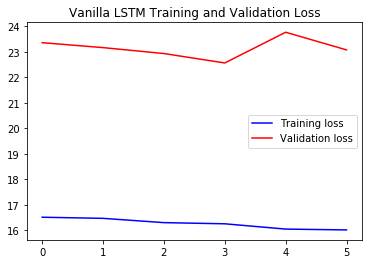


Validation:
MAPE: 23.07998687028885
MSE: 7541.008
CV(RMSE): 49.18828358436642
MBE: -23.496984

Test:
MAPE: 19.802840054035187
MSE: 3494.1978
CV(RMSE): 35.67895756337937
MBE: -14.497029

Fold #4


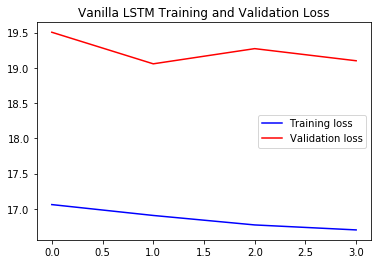


Validation:
MAPE: 19.100666046142578
MSE: 2973.3772
CV(RMSE): 32.9126930226698
MBE: -11.8147

Test:
MAPE: 20.473672449588776
MSE: 5878.22
CV(RMSE): 43.567248521028155
MBE: -15.113389

4-Fold Average

Validation:
MAPE: 32.134782895445824
MSE: 7262.003601074219
CV(RMSE): 47.76044766076404
MBE: -13.680128455162048

Test:
MAPE: 22.37468659877777
MSE: 6851.1595458984375
CV(RMSE): 47.60068303554896
MBE: -17.184772968292236
-----Experiment #9-----

Fold #1
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_118 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable pa

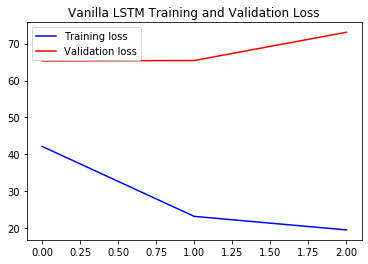


Validation:
MAPE: 73.07319045066833
MSE: 14613.58
CV(RMSE): 69.30006421413178
MBE: -2.288426

Test:
MAPE: 26.123332977294922
MSE: 9987.193
CV(RMSE): 60.48609773266324
MBE: -21.188587

Fold #2


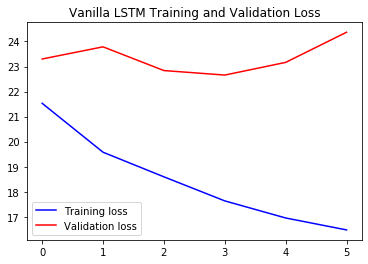


Validation:
MAPE: 24.36928302049637
MSE: 4320.4463
CV(RMSE): 39.783057654702006
MBE: -4.321742

Test:
MAPE: 23.82468730211258
MSE: 6869.4526
CV(RMSE): 46.94702389086109
MBE: -18.935022

Fold #3


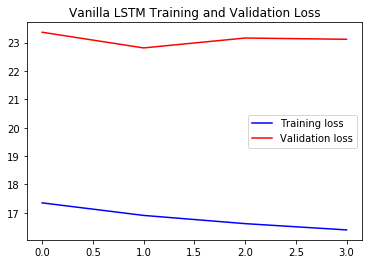


Validation:
MAPE: 23.118436336517334
MSE: 6397.5234
CV(RMSE): 45.305708587968404
MBE: -14.35317

Test:
MAPE: 19.740135967731476
MSE: 2690.8528
CV(RMSE): 31.310023713845318
MBE: -8.87089

Fold #4


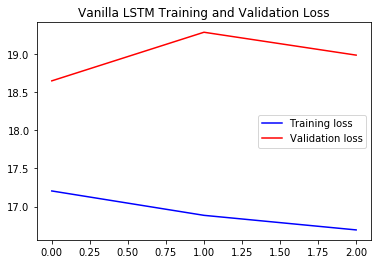


Validation:
MAPE: 18.98515373468399
MSE: 2405.5645
CV(RMSE): 29.603762901333898
MBE: -8.461099

Test:
MAPE: 20.483477413654327
MSE: 5051.762
CV(RMSE): 40.38858626003337
MBE: -14.804718

4-Fold Average

Validation:
MAPE: 34.88651588559151
MSE: 6934.278564453125
CV(RMSE): 45.998148339534026
MBE: -7.356109261512756

Test:
MAPE: 22.542908415198326
MSE: 6149.815246582031
CV(RMSE): 44.782932899350754
MBE: -15.949804306030273
-----Experiment #10-----

Fold #1
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_120 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable

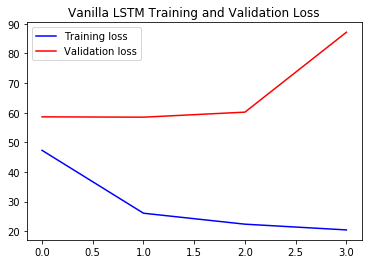


Validation:
MAPE: 87.14881539344788
MSE: 17151.543
CV(RMSE): 75.07700053787318
MBE: -15.883227

Test:
MAPE: 28.381720185279846
MSE: 12512.492
CV(RMSE): 67.70266493756064
MBE: -28.917856

Fold #2


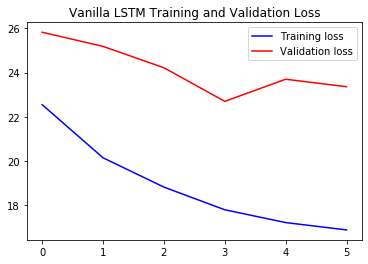


Validation:
MAPE: 23.359684646129608
MSE: 6834.7646
CV(RMSE): 50.03750480469703
MBE: -12.098862

Test:
MAPE: 24.411271512508392
MSE: 11707.147
CV(RMSE): 61.28758635812013
MBE: -28.577438

Fold #3


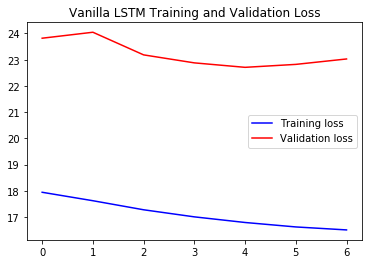


Validation:
MAPE: 23.027992248535156
MSE: 8626.1
CV(RMSE): 52.60829547893261
MBE: -22.224123

Test:
MAPE: 19.934096932411194
MSE: 3875.452
CV(RMSE): 37.57505209162231
MBE: -12.073975

Fold #4


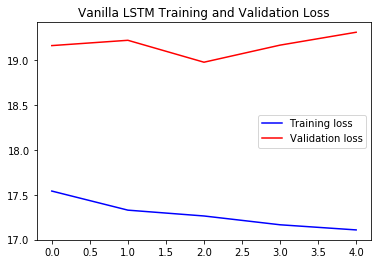


Validation:
MAPE: 19.30738091468811
MSE: 3475.9507
CV(RMSE): 35.58567662743954
MBE: -10.852865

Test:
MAPE: 20.91974914073944
MSE: 7036.149
CV(RMSE): 47.665557791841366
MBE: -19.138157

4-Fold Average

Validation:
MAPE: 38.21096830070019
MSE: 9022.089477539062
CV(RMSE): 53.327119362235585
MBE: -15.264769315719604

Test:
MAPE: 23.41170944273472
MSE: 8782.810119628906
CV(RMSE): 53.55771529478611
MBE: -22.176856517791748
-----Experiment #11-----

Fold #1
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_122 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_123 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable 

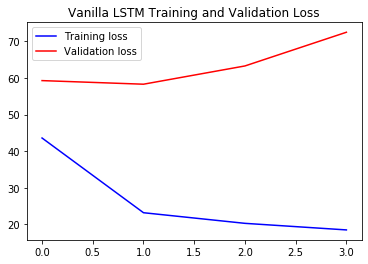


Validation:
MAPE: 72.51781225204468
MSE: 12792.854
CV(RMSE): 64.83940825028694
MBE: -3.7938735

Test:
MAPE: 24.521051347255707
MSE: 9133.624
CV(RMSE): 57.8436113368131
MBE: -21.873287

Fold #2


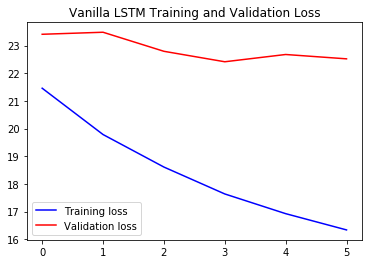


Validation:
MAPE: 22.51991629600525
MSE: 4491.823
CV(RMSE): 40.5644108310108
MBE: -8.315457

Test:
MAPE: 23.58715981245041
MSE: 6836.4424
CV(RMSE): 46.83408947061229
MBE: -18.016897

Fold #3


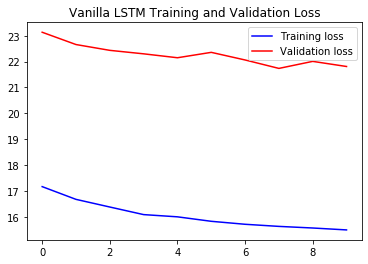


Validation:
MAPE: 21.81033492088318
MSE: 6076.885
CV(RMSE): 44.15577231750177
MBE: -16.55379

Test:
MAPE: 18.870723247528076
MSE: 2547.9487
CV(RMSE): 30.467285613870665
MBE: -7.8442535

Fold #4


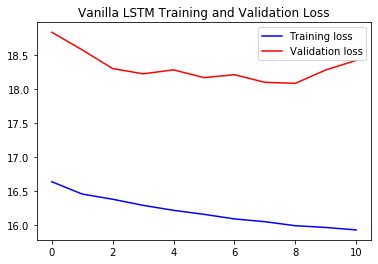


Validation:
MAPE: 18.423569202423096
MSE: 2184.703
CV(RMSE): 28.212048084914503
MBE: -6.230528

Test:
MAPE: 19.89772319793701
MSE: 4273.961
CV(RMSE): 37.149454106177984
MBE: -12.732236

4-Fold Average

Validation:
MAPE: 33.81790816783905
MSE: 6386.566101074219
CV(RMSE): 44.4429098709285
MBE: -8.723411977291107

Test:
MAPE: 21.7191644012928
MSE: 5697.9940185546875
CV(RMSE): 43.07361013186851
MBE: -15.116668462753296
-----Experiment #12-----

Fold #1
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_124 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable par

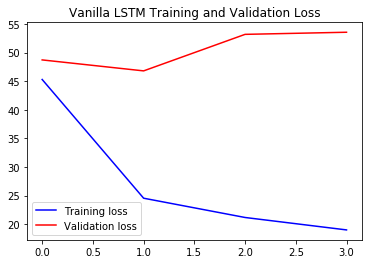


Validation:
MAPE: 53.55125665664673
MSE: 11782.438
CV(RMSE): 62.2261485088037
MBE: -5.167927

Test:
MAPE: 24.782216548919678
MSE: 8281.689
CV(RMSE): 55.079924669000015
MBE: -18.801294

Fold #2


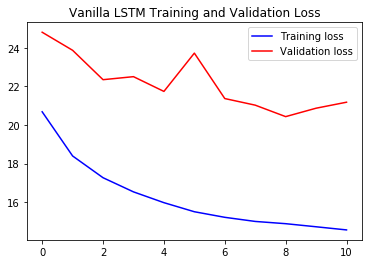


Validation:
MAPE: 21.17519974708557
MSE: 3775.6724
CV(RMSE): 37.19041219821377
MBE: -5.148799

Test:
MAPE: 22.987931966781616
MSE: 6061.637
CV(RMSE): 44.10034011268291
MBE: -14.606229

Fold #3


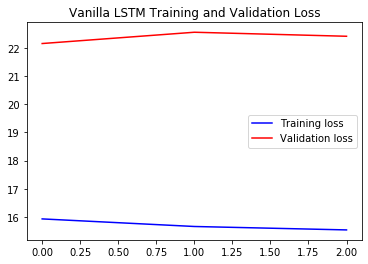


Validation:
MAPE: 22.409678995609283
MSE: 5570.9883
CV(RMSE): 42.277870791406976
MBE: -11.325633

Test:
MAPE: 19.039826095104218
MSE: 2359.9297
CV(RMSE): 29.321619902094273
MBE: -5.622087

Fold #4


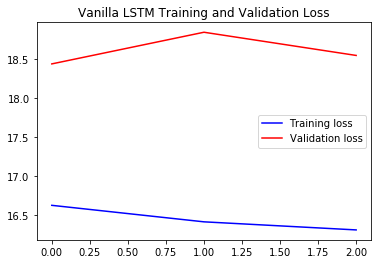


Validation:
MAPE: 18.541251122951508
MSE: 2329.2952
CV(RMSE): 29.130683291777924
MBE: -8.296399

Test:
MAPE: 20.014318823814392
MSE: 4852.4453
CV(RMSE): 39.583800831907574
MBE: -13.848671

4-Fold Average

Validation:
MAPE: 28.919346630573273
MSE: 5864.598571777344
CV(RMSE): 42.706278697550594
MBE: -7.484689474105835

Test:
MAPE: 21.706073358654976
MSE: 5388.9254150390625
CV(RMSE): 42.0214213789212
MBE: -13.219570279121399
-----Experiment #13-----

Fold #1
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_126 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-traina

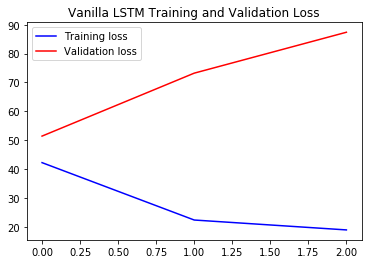


Validation:
MAPE: 87.3896837234497
MSE: 13179.809
CV(RMSE): 65.81272339034521
MBE: 3.0145843

Test:
MAPE: 25.741833448410034
MSE: 9003.579
CV(RMSE): 57.43034736227905
MBE: -18.920647

Fold #2


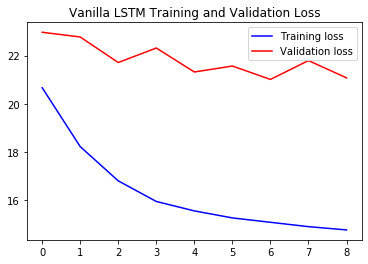


Validation:
MAPE: 21.077731251716614
MSE: 3741.1455
CV(RMSE): 37.019978211934195
MBE: -7.82686

Test:
MAPE: 22.692756354808807
MSE: 6097.9185
CV(RMSE): 44.23212502622086
MBE: -16.07458

Fold #3


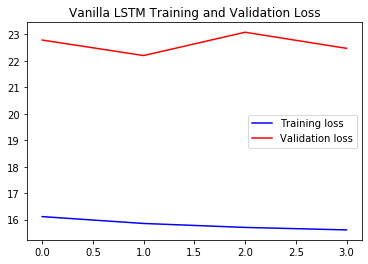


Validation:
MAPE: 22.465355694293976
MSE: 5818.234
CV(RMSE): 43.20585352328339
MBE: -11.220205

Test:
MAPE: 18.758492171764374
MSE: 2394.835
CV(RMSE): 29.537667511037235
MBE: -7.3230314

Fold #4


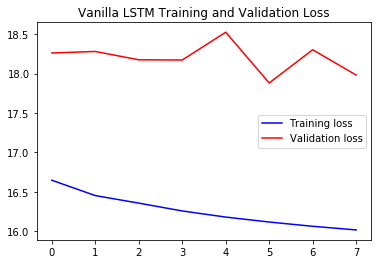


Validation:
MAPE: 17.98037588596344
MSE: 2212.7686
CV(RMSE): 28.392681034965488
MBE: -6.7299967

Test:
MAPE: 19.861720502376556
MSE: 4588.51
CV(RMSE): 38.49222562154622
MBE: -11.33569

4-Fold Average

Validation:
MAPE: 37.228286638855934
MSE: 6237.9891357421875
CV(RMSE): 43.60780904013207
MBE: -5.69061940908432

Test:
MAPE: 21.763700619339943
MSE: 5521.2105712890625
CV(RMSE): 42.42309138027084
MBE: -13.41348671913147
-----Experiment #14-----

Fold #1
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_128 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_129 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainable p

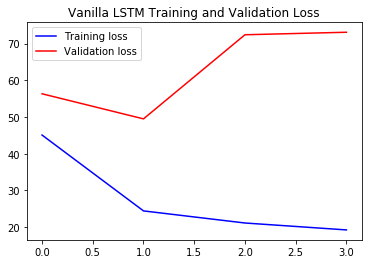


Validation:
MAPE: 73.084557056427
MSE: 13707.547
CV(RMSE): 67.1174091675317
MBE: 0.33571106

Test:
MAPE: 25.493717193603516
MSE: 9585.658
CV(RMSE): 59.25770224565213
MBE: -18.475094

Fold #2


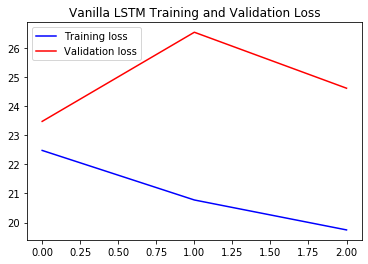


Validation:
MAPE: 24.616333842277527
MSE: 7874.4385
CV(RMSE): 53.70857501505826
MBE: -16.383493

Test:
MAPE: 26.347288489341736
MSE: 12024.982
CV(RMSE): 62.113957065992025
MBE: -30.114325

Fold #3


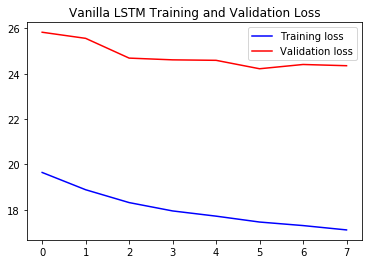


Validation:
MAPE: 24.355319142341614
MSE: 8530.733
CV(RMSE): 52.31667895276305
MBE: -21.890224

Test:
MAPE: 20.116592943668365
MSE: 3511.7212
CV(RMSE): 35.76831044470183
MBE: -13.003752

Fold #4


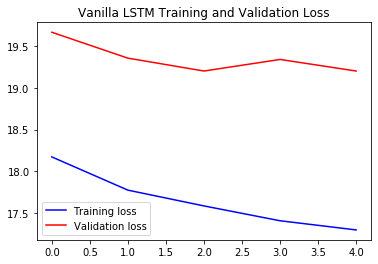


Validation:
MAPE: 19.199155271053314
MSE: 2923.6167
CV(RMSE): 32.63612896618392
MBE: -10.656253

Test:
MAPE: 20.910198986530304
MSE: 6112.923
CV(RMSE): 44.42849795005849
MBE: -18.773363

4-Fold Average

Validation:
MAPE: 35.313841328024864
MSE: 8259.083862304688
CV(RMSE): 51.444698025384234
MBE: -12.148564919829369

Test:
MAPE: 23.21694940328598
MSE: 7808.8211669921875
CV(RMSE): 50.39211692660112
MBE: -20.091633319854736
-----Experiment #15-----

Fold #1
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 8)                 1504      
_________________________________________________________________
dense_130 (Dense)            (None, 32)                288       
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 33        
Total params: 1,825
Trainable params: 1,825
Non-trainab

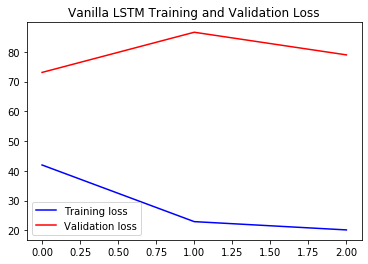


Validation:
MAPE: 78.9563000202179
MSE: 14668.033
CV(RMSE): 69.42905668032095
MBE: -7.038924

Test:
MAPE: 26.491418480873108
MSE: 11171.97
CV(RMSE): 63.97329650517282
MBE: -24.088428

Fold #2


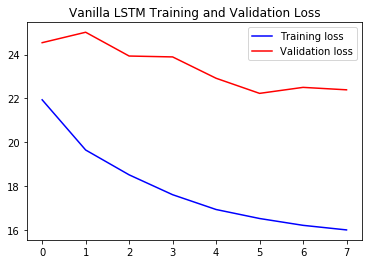


Validation:
MAPE: 22.394739091396332
MSE: 4827.2393
CV(RMSE): 42.05167351222476
MBE: -7.4536953

Test:
MAPE: 24.1021990776062
MSE: 7797.611
CV(RMSE): 50.01816769229426
MBE: -20.289087

Fold #3


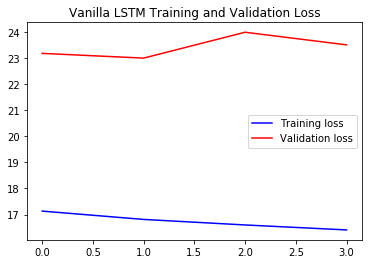


Validation:
MAPE: 23.521587252616882
MSE: 6818.333
CV(RMSE): 46.772015081431796
MBE: -17.209526

Test:
MAPE: 19.52512115240097
MSE: 2908.8977
CV(RMSE): 32.553870068610635
MBE: -10.312502

Fold #4


KeyboardInterrupt: 

In [124]:
lstm_model = None

# utils.walk_forward_cv(
#     lstm_model, 
#     train_folds, 
#     val_folds, 
#     test_folds, 
#     callbacks=callbacks,
#     verbose=verbose, 
#     model_name="Vanilla LSTM"
# )

metrics = np.zeros((2,4))

for i in range(N):
    lstm_model = Sequential()
    lstm_model.add(LSTM(8, input_shape = (timesteps, n_features)))
    lstm_model.add(Dense(32, activation='relu'))
    lstm_model.add(Dense(1))
    print("-----Experiment #" + str(i + 1) + "-----")
    metrics = metrics + utils.walk_forward_cv(
        lstm_model, 
        train_folds, 
        val_folds, 
        test_folds, 
        callbacks=callbacks,
        verbose=verbose, 
        model_name="Vanilla LSTM"
    ) / N
    
print("\nOverall Validation:")
utils.print_metrics(*metrics[0])
print("\nOverall Test:")
utils.print_metrics(*metrics[1])

# Overall Validation:
# MAPE: 50.77106049284339
# MSE: 9434.811126708984
# CV(RMSE): 54.157817864135325
# MBE: -14.903981592878699

# Overall Test:
# MAPE: 42.56542481482029
# MSE: 8869.950701904296
# CV(RMSE): 54.161317168255835
# MBE: -20.77920241802931

### CNN

In [127]:
cnn_model = None

# utils.walk_forward_cv(
#     cnn_model, 
#     train_folds, 
#     val_folds, 
#     test_folds, 
#     callbacks=callbacks,
#     verbose=verbose, 
#     model_name="CNN"
# )

metrics = np.zeros((2,4))

for i in range(N):
    cnn_model = Sequential()
    cnn_model.add(Conv1D(8, kernel_size=2, input_shape = (timesteps, n_features)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(32, activation='relu'))
    cnn_model.add(Dense(1))
    
    print("-----Experiment #" + str(i + 1) + "-----")
    metrics = metrics + utils.walk_forward_cv(
        cnn_model, 
        train_folds, 
        val_folds, 
        test_folds, 
        callbacks=callbacks,
        verbose=verbose, 
        model_name="CNN"
    ) / N
    
print("\nOverall Validation:")
utils.print_metrics(*metrics[0])
print("\nOverall Test:")
utils.print_metrics(*metrics[1])

# Overall Validation:
# MAPE: 39.318471290171146
# MSE: 8778.81907043457
# CV(RMSE): 54.12282267014075
# MBE: -17.353715103864673

# Overall Test:
# MAPE: 41.622185446321964
# MSE: 8367.039208984375
# CV(RMSE): 53.45222762279509
# MBE: -20.648522400856017

-----Experiment #1-----

Fold #1
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 23, 8)             616       
_________________________________________________________________
flatten_16 (Flatten)         (None, 184)               0         
_________________________________________________________________
dense_144 (Dense)            (None, 32)                5920      
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 33        
Total params: 6,569
Trainable params: 6,569
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

## Sequence Experiments

In [98]:
importlib.reload(utils)

# Combined simulation and observed data into properly formatted dataframe
energy = utils.get_energy_df(energy_retrofit_baseline, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building')

train_folds, val_folds, test_folds = utils.make_seq_folds(folds, energy, timesteps, scalers=None)

n_features = train_folds[0][0].shape[-1]
    
val_agg_ref = []
test_agg_ref = []

for idx, fold in enumerate(folds):
    val_agg_ref.append(utils.equalize_timesteps(energy, fold[1], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    val_agg_ref[idx]['kwh_actual'] = val_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))
    test_agg_ref.append(utils.equalize_timesteps(energy, fold[2], timesteps, one_hot=False).filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual']))
    test_agg_ref[idx]['kwh_actual'] = test_agg_ref[idx]['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

Retrieving DUE-S Energy Data...
Processing Fold #1...
Train: (5220, 24, 30) (5220, 24, 1)
Val: (5307, 24, 30) (5307, 24, 1)
Test: (5220, 24, 30) (5220, 24, 1)
Processing Fold #2...
Train: (10556, 24, 30) (10556, 24, 1)
Val: (5220, 24, 30) (5220, 24, 1)
Test: (5307, 24, 30) (5307, 24, 1)
Processing Fold #3...
Train: (15805, 24, 30) (15805, 24, 1)
Val: (5307, 24, 30) (5307, 24, 1)
Test: (10556, 24, 30) (10556, 24, 1)


In [230]:
# energy = utils.get_energy_df(energy_sim, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building')

# energy_train = utils.equalize_timesteps(energy, 'year <= 2017', timesteps)
# energy_val = utils.equalize_timesteps(energy, 'year == 2018 and month < 7', timesteps)
# energy_test= utils.equalize_timesteps(energy, 'year == 2018 and month >= 7', timesteps)

# standard_scaler = utils.preprocessing.StandardScaler()
# standard_scaler.fit(energy_train.drop(columns='kwh_actual'))

# train_x, train_y = utils.preprocess(energy_train, None, standard_scaler, n_in=timesteps, df_name="Train", remove_target=False, to_supervised=False)
# val_x, val_y = utils.preprocess(energy_val, None, standard_scaler, n_in=timesteps, df_name="Validation", remove_target=False, to_supervised=False)
# test_x, test_y = utils.preprocess(energy_test, None, standard_scaler, n_in=timesteps, df_name="Test", remove_target=False, to_supervised=False)

# n_features = train_x.shape[-1]

In [231]:
model_hold = lstm_model

### Vanilla LSTM

-----Experiment #1-----

Fold #1
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 24, 64)            24320     
_________________________________________________________________
lstm_22 (LSTM)               (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_23 (TimeDis (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_24 (TimeDis (None, 24, 1)             33        
Total params: 59,457
Trainable params: 59,457
Non-trainable params: 0
_________________________________________________________________
Train on 5220 samples, validate on 5307 samples
Epoch 1/30
5220/5220 [==============================] - 6s 1ms/step - loss: 147.5295 - val_loss: 132.6370
Epoch 2/30
5220/5220 [==============================] - 5s 9

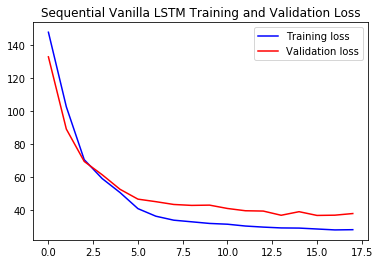

31.61354959011078
32.528239488601685

Fold #2
Train on 10556 samples, validate on 5220 samples
Epoch 1/30
10556/10556 [==============================] - 10s 920us/step - loss: 30.7299 - val_loss: 35.1989
Epoch 2/30
10556/10556 [==============================] - 9s 836us/step - loss: 30.4554 - val_loss: 35.4786
Epoch 3/30
10556/10556 [==============================] - 9s 887us/step - loss: 30.0223 - val_loss: 37.8238


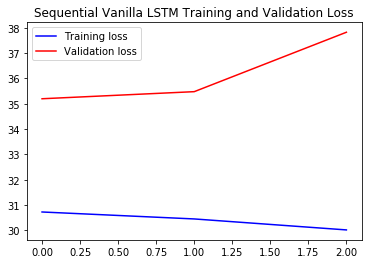

32.86510407924652
33.50501358509064

Fold #3
Train on 15805 samples, validate on 5307 samples
Epoch 1/30
15805/15805 [==============================] - 13s 853us/step - loss: 30.2104 - val_loss: 38.8749
Epoch 2/30
15805/15805 [==============================] - 13s 799us/step - loss: 29.8087 - val_loss: 39.5390
Epoch 3/30
15805/15805 [==============================] - 13s 799us/step - loss: 29.5989 - val_loss: 39.0706


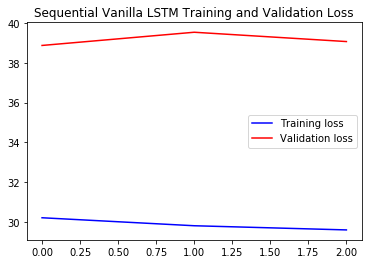

31.31932020187378
28.220191597938538
[[[3.19326582e+01 7.33800183e+03 4.97893840e+01 1.58848160e+00]
  [2.35707652e+01 1.68112087e+06 3.14427138e+01 3.88918701e+01]
  [1.69334165e+01 5.32749704e+08 1.84399729e+01 1.27581531e+03]]

 [[1.75378240e+01 1.47154221e+06 2.43411669e+01 4.59146064e+01]
  [1.41682007e+01 4.18204143e+08 1.71090113e+01 1.12735763e+03]
  [9.73972779e+00 1.38781169e+11 1.02950410e+01 3.65238499e+04]]]
[[[3.14178145e+01 7.31172366e+03 4.98042803e+01 2.01810118e+00]
  [2.23094370e+01 1.58566616e+06 3.06084476e+01 4.95390848e+01]
  [1.56141116e+01 4.69550693e+08 1.71787429e+01 1.69620753e+03]]

 [[1.74730430e+01 1.48263431e+06 2.44214136e+01 5.84638153e+01]
  [1.36346591e+01 3.90406080e+08 1.65142982e+01 1.43623501e+03]
  [8.78339240e+00 1.21357794e+11 9.36509529e+00 4.90864967e+04]]]


In [99]:
lstm_model = None
N = 1
importlib.reload(utils)
# utils.walk_forward_cv(
#     lstm_model, 
#     train_folds, 
#     val_folds, 
#     test_folds, 
#     callbacks=callbacks,
#     verbose=verbose, 
#     model_name="Sequential Vanilla LSTM"
# )

metrics = np.zeros((2, 2, 3, 4))

for i in range(N):
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=True))
    lstm_model.add(LSTM(64, return_sequences=True))
    lstm_model.add(TimeDistributed(Dense(32, activation='relu')))
    lstm_model.add(TimeDistributed(Dense(1)))
    
    print("-----Experiment #" + str(i + 1) + "-----")
    metrics = metrics + utils.walk_forward_cv(
        lstm_model, 
        train_folds, 
        val_folds, 
        test_folds, 
        callbacks=callbacks,
        loss = 'mean_absolute_error',
        verbose=1, 
        model_name="Sequential Vanilla LSTM",
        val_agg_df=val_agg_ref,
        test_agg_df=test_agg_ref
    ) / N

print(metrics[0])
print(metrics[1])
    
# print("\nOverall Validation:")
# utils.print_metrics(*metrics[0])
# print("\nOverall Test:")
# utils.print_metrics(*metrics[1])

# [[[ 2.88679761e+01  2.00533960e+04  7.74653839e+01 -4.40361485e+01]
#   [ 2.27238199e+01  8.25891031e+06  6.18286913e+01 -1.05504085e+03]
#   [ 2.02786641e+01  6.60678219e+09  5.78761623e+01 -3.13274806e+04]]

#  [[ 2.49765546e+01  3.87282563e+06  3.57806500e+01 -1.27545859e+03]
#   [ 2.50692000e+01  1.67317137e+09  2.93211194e+01 -3.05862832e+04]
#   [ 2.51523071e+01  1.31774564e+12  2.73963219e+01 -9.05877354e+05]]]

### Seq2Seq LSTM

-----Experiment #1-----

Fold #1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 64)                31488     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 24, 1)             33        
Total params: 66,625
Trainable params: 66,625
Non-trainable params: 0
_________________________________________________________________


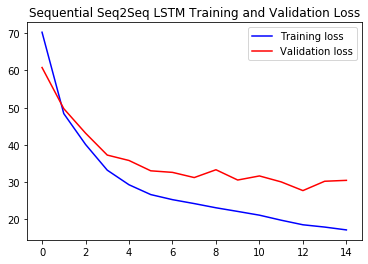

30.487841367721558
30.241340398788452

Fold #2


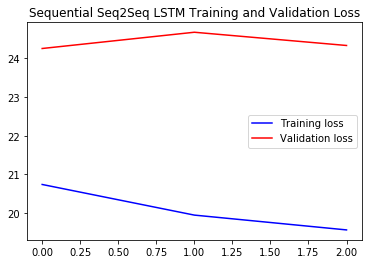

24.328622221946716
27.64970064163208

Fold #3


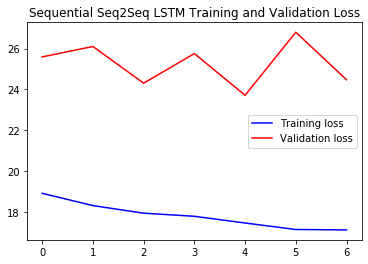

24.471579492092133
21.960191428661346

Fold #4


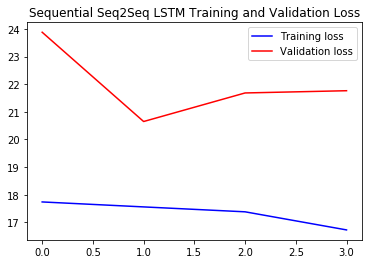

21.765024960041046
23.39194118976593
[[[ 2.52632685e+01  9.05611336e+03  5.55399035e+01 -1.72687975e+01]
  [ 1.84337874e+01  2.36630255e+06  3.71433891e+01 -4.13589120e+02]
  [ 1.41255821e+01  1.44670132e+09  3.03172716e+01 -1.22229179e+04]]

 [[ 1.28907668e+01  1.20169531e+06  2.19960376e+01 -5.00338357e+02]
  [ 1.12132246e+01  3.34081621e+08  1.51352303e+01 -1.19894877e+04]
  [ 9.55061411e+00  1.81573553e+11  1.17164067e+01 -3.54061369e+05]]]
[[[ 2.58107943e+01  9.37922415e+03  5.55284760e+01 -1.82692538e+01]
  [ 1.84813030e+01  2.53300060e+06  3.76947373e+01 -4.37277673e+02]
  [ 1.44984432e+01  1.70474121e+09  3.18942098e+01 -1.30177532e+04]]

 [[ 1.26738465e+01  1.24239938e+06  2.20573869e+01 -5.29307447e+02]
  [ 1.11190392e+01  3.48876663e+08  1.51604024e+01 -1.26774304e+04]
  [ 9.84353176e+00  2.20125438e+11  1.23126248e+01 -3.77097199e+05]]]


In [44]:
lstm_autoencoder_model = None

# utils.walk_forward_cv(
#     lstm_autoencoder_model, 
#     train_folds, 
#     val_folds, 
#     test_folds, 
#     callbacks=callbacks,
#     verbose=verbose, 
#     model_name="Sequential Seq2Seq LSTM"
# )

metrics = np.zeros((2, 2, 3, 4))

for i in range(N):
    lstm_autoencoder_model = Sequential()
    lstm_autoencoder_model.add(LSTM(64, input_shape=(timesteps, n_features), return_sequences=False))
    lstm_autoencoder_model.add(RepeatVector(timesteps))
    lstm_autoencoder_model.add(LSTM(64, return_sequences=True))
    lstm_autoencoder_model.add(TimeDistributed(Dense(32, activation='relu')))
    lstm_autoencoder_model.add(TimeDistributed(Dense(1)))

    print("-----Experiment #" + str(i + 1) + "-----")
    metrics = metrics + utils.walk_forward_cv(
        lstm_autoencoder_model, 
        train_folds, 
        val_folds, 
        test_folds, 
        callbacks=callbacks,
        verbose=verbose, 
        model_name="Sequential Seq2Seq LSTM",
        val_agg_df=val_agg_ref,
        test_agg_df=test_agg_ref
    ) / N

print(metrics[0])
print(metrics[1])

# 29%

### CNN-LSTM

-----Experiment #1-----

Fold #1
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 23, 64)            7488      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 704)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 24, 704)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 24, 64)            196864    
_________________________________________________________________
time_distributed_11 (TimeDis (None, 24, 32)            2080      
_________________________________________________________________
time_distributed_12 (

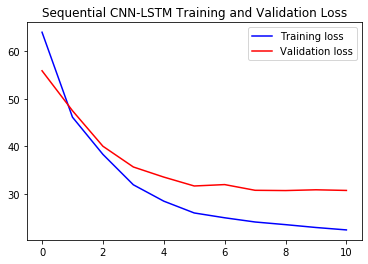

30.74512779712677
28.835025429725647

Fold #2
Train on 10556 samples, validate on 5220 samples
Epoch 1/30
10556/10556 [==============================] - 11s 1ms/step - loss: 25.2528 - val_loss: 27.3001
Epoch 2/30
10556/10556 [==============================] - 10s 970us/step - loss: 24.0533 - val_loss: 26.8532
Epoch 3/30
10556/10556 [==============================] - 10s 972us/step - loss: 23.2763 - val_loss: 26.4716
Epoch 4/30
10556/10556 [==============================] - 10s 969us/step - loss: 22.8102 - val_loss: 28.2177
Epoch 5/30
10556/10556 [==============================] - 10s 971us/step - loss: 22.5230 - val_loss: 25.9188
Epoch 6/30
10556/10556 [==============================] - 10s 977us/step - loss: 22.4568 - val_loss: 27.4869
Epoch 7/30
10556/10556 [==============================] - 10s 972us/step - loss: 22.2297 - val_loss: 27.7651


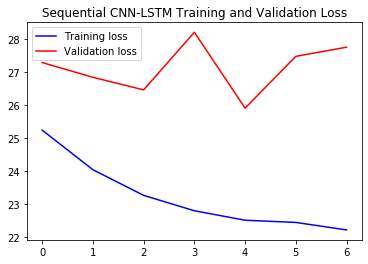

27.765142917633057
28.14447283744812

Fold #3
Train on 15805 samples, validate on 5307 samples
Epoch 1/30
15805/15805 [==============================] - 15s 953us/step - loss: 22.8884 - val_loss: 27.2699
Epoch 2/30
15805/15805 [==============================] - 14s 914us/step - loss: 22.6050 - val_loss: 26.7472
Epoch 3/30
15805/15805 [==============================] - 14s 913us/step - loss: 22.3651 - val_loss: 26.8479
Epoch 4/30
15805/15805 [==============================] - 15s 921us/step - loss: 22.1976 - val_loss: 26.8743


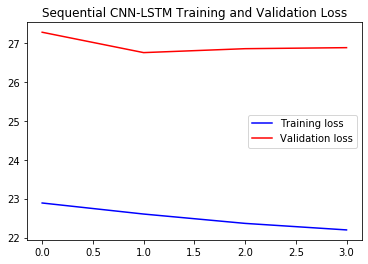

26.874327659606934
25.732553005218506

Fold #4
Train on 21141 samples, validate on 5220 samples
Epoch 1/30
21141/21141 [==============================] - 19s 898us/step - loss: 22.9176 - val_loss: 25.5232
Epoch 2/30
21141/21141 [==============================] - 18s 856us/step - loss: 22.4620 - val_loss: 24.8757
Epoch 3/30
21141/21141 [==============================] - 18s 858us/step - loss: 22.0713 - val_loss: 24.4459
Epoch 4/30
21141/21141 [==============================] - 18s 855us/step - loss: 20.7369 - val_loss: 22.5819
Epoch 5/30
21141/21141 [==============================] - 18s 854us/step - loss: 19.3279 - val_loss: 23.7842
Epoch 6/30
21141/21141 [==============================] - 18s 852us/step - loss: 18.4870 - val_loss: 22.8446


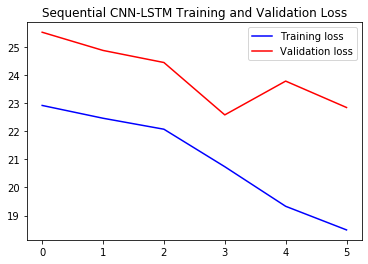

22.844551503658295
22.877362370491028
[[[ 2.70572878e+01  1.29374878e+04  6.51927148e+01 -2.90607198e+01]
  [ 2.16101444e+01  3.82488268e+06  4.60673845e+01 -6.96518469e+02]
  [ 1.88435447e+01  2.69487441e+09  3.98470511e+01 -2.08209460e+04]]

 [[ 1.71842145e+01  2.49818859e+06  3.08614343e+01 -8.42061117e+02]
  [ 1.66609004e+01  7.35267564e+08  2.19230133e+01 -2.01920004e+04]
  [ 1.60824825e+01  5.09314066e+11  1.87893060e+01 -6.03139880e+05]]]
[[[ 2.63973522e+01  1.27643579e+04  6.56897157e+01 -3.14558808e+01]
  [ 2.15118670e+01  3.81724832e+06  4.69841446e+01 -7.53783945e+02]
  [ 1.93584448e+01  2.68298288e+09  4.13801883e+01 -2.24884267e+04]]

 [[ 1.74057461e+01  2.51640061e+06  3.17465786e+01 -9.11250968e+02]
  [ 1.75296693e+01  7.56728960e+08  2.27931808e+01 -2.18527229e+04]
  [ 1.75329340e+01  5.31318654e+11  2.00594053e+01 -6.51121428e+05]]]


In [45]:
cnn_lstm_model = None

# utils.walk_forward_cv(
#     cnn_lstm_model, 
#     train_folds, 
#     val_folds, 
#     test_folds, 
#     callbacks=callbacks,
#     verbose=verbose, 
#     model_name="Sequential CNN-LSTM"
# )

metrics = np.zeros((2, 2, 3, 4))

for i in range(N):
    cnn_lstm_model = Sequential()
    cnn_lstm_model.add(Conv1D(64, activation='relu', kernel_size=2, input_shape=(timesteps, n_features)))
    cnn_lstm_model.add(MaxPooling1D(pool_size=2))
    cnn_lstm_model.add(Flatten())
    cnn_lstm_model.add(RepeatVector(timesteps))
    cnn_lstm_model.add(LSTM(64, return_sequences=True))
    cnn_lstm_model.add(TimeDistributed(Dense(32, activation='relu')))
    cnn_lstm_model.add(TimeDistributed(Dense(1)))
    
    print("-----Experiment #" + str(i + 1) + "-----")
    metrics = metrics + utils.walk_forward_cv(
        cnn_lstm_model, 
        train_folds, 
        val_folds, 
        test_folds, 
        callbacks=callbacks,
        verbose=1, 
        model_name="Sequential CNN-LSTM",
        val_agg_df=val_agg_ref,
        test_agg_df=test_agg_ref
    ) / N

print(metrics[0])
print(metrics[1])

# 28.2%

In [295]:
# energy_urban_monthly = utils.get_energy_df(energy_sim, energy_actual, spatial_scale='urban', temporal_scale = 'month')
# energy_urban_daily = utils.get_energy_df(energy_sim, energy_actual, spatial_scale='urban', temporal_scale = 'day')
# energy_urban_hourly = utils.get_energy_df(energy_sim, energy_actual, spatial_scale='urban', temporal_scale = 'hour')
# energy_building_monthly = utils.get_energy_df(energy_sim, energy_actual, spatial_scale='building', temporal_scale = 'month')
# energy_building_daily = utils.get_energy_df(energy_sim, energy_actual, spatial_scale='building', temporal_scale = 'day')

In [296]:
# ['month', 'kwh', 'kwh_actual', 'target_00600340190000',
#        'target_00600470060000', 'target_00600470080000',
#        'target_00600470120000', 'target_00600910010000',
#        'target_00600940090000', 'target_00600960230000',
#        'target_00600970130000', 'target_00600970150000',
#        'target_00601010030000', 'target_00601010110000',
#        'target_00601010140000', 'target_00601010150000',
#        'target_00601010190000', 'target_00601010210000',
#        'target_00601020070000', 'target_00601020160000',
#        'target_00601020190000', 'target_00601020200000',
#        'target_00601030100000', 'target_00601030110000',
#        'target_00601040010000', 'target_00601060050000',
#        'target_00601060060000', 'target_00601450250000',
#        'target_00601510200000', 'target_00601530150000',
#        'target_00601550120000', 'target_00603700370000', 'wday_1', 'wday_2',
#        'wday_3', 'wday_4', 'wday_5', 'wday_6', 'wday_7']

In [114]:
tf.random.set_seed(77)
os.environ['PYTHONHASHSEED'] = str(77)
np.random.seed(77)
random.seed(77)

# Data read and formatting

PATH_RETROFIT_ROOT = "../data/old/"
PATH_ENERGY_BASELINE = "../data/all/building_energy_retrofit_baseline.csv"
PATH_ENERGY_FULL = PATH_RETROFIT_ROOT + "building_energy_retrofit_full.csv"
PATH_ENERGY_LIGHT = PATH_RETROFIT_ROOT + "building_energy_retrofit_light.csv"
PATH_ENERGY_WINDOW = PATH_RETROFIT_ROOT + "building_energy_retrofit_window.csv"
PATH_ENERGY_FEATURIZED = "../data/building_energy_featurized.csv"
PATH_DISTANCES = "D:/smud/smud_distances.csv"
PATH_ENERGY_ACTUAL = "../data/building_energy_actual.csv"
PATH_ENERGY_ACTUAL_STATIONARY = "../data/building_energy_actual_stationary.csv"
PATH_ENERGY_SIM = "../data/building_energy_sim.csv"

energy_dtype = {
    'apn': str, 
    'year': np.float32, 
    'month': np.float32, 
    'day': np.float32, 
    'hour': np.float32, 
    'kwh': np.float32
}

energy_retrofit_baseline = pd.read_csv(PATH_ENERGY_BASELINE, dtype=energy_dtype)
energy_retrofit_full = pd.read_csv(PATH_ENERGY_FULL, dtype=energy_dtype)
energy_retrofit_light = pd.read_csv(PATH_ENERGY_LIGHT, dtype=energy_dtype)
energy_retrofit_window = pd.read_csv(PATH_ENERGY_WINDOW, dtype=energy_dtype)

# energy_featurized = pd.read_csv(PATH_ENERGY_FEATURIZED, dtype=np.float32)
# dist = pd.read_csv(PATH_DISTANCES, dtype=str)
energy_actual = pd.read_csv(PATH_ENERGY_ACTUAL_STATIONARY, dtype=energy_dtype)
# energy_sim = pd.read_csv(PATH_ENERGY_SIM, dtype=energy_dtype)

In [115]:
energy_retrofits = utils.equalize_timesteps(energy, fold[2], timesteps, one_hot=False)
energy_retrofits = energy_retrofits.filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual'])
energy_retrofits['kwh_actual'] = energy_retrofits['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))

scalers = utils.make_seq_folds(folds, energy, timesteps, scalers=None, get_scalers=True)

energy_full = utils.get_energy_df(energy_retrofit_full, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building')
full_train_folds, full_val_folds, full_test_folds = utils.make_seq_folds(folds, energy_full, timesteps, scalers)

energy_light = utils.get_energy_df(energy_retrofit_light, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building')
light_train_folds, light_val_folds, light_test_folds = utils.make_seq_folds(folds, energy_light, timesteps, scalers)

energy_window = utils.get_energy_df(energy_retrofit_window, energy_actual, one_hot=False, temporal_scale='hour', spatial_scale='building')
window_train_folds, window_val_folds, window_test_folds = utils.make_seq_folds(folds, energy_window, timesteps, scalers)

Processing Fold #1...
Processing Fold #2...
Processing Fold #3...
Retrieving DUE-S Energy Data...
Processing Fold #1...
Train: (5220, 24, 30) (5220, 24, 1)
Val: (5307, 24, 30) (5307, 24, 1)
Test: (5220, 24, 30) (5220, 24, 1)
Processing Fold #2...
Train: (10556, 24, 30) (10556, 24, 1)
Val: (5220, 24, 30) (5220, 24, 1)
Test: (5307, 24, 30) (5307, 24, 1)
Processing Fold #3...
Train: (15805, 24, 30) (15805, 24, 1)
Val: (5307, 24, 30) (5307, 24, 1)
Test: (10556, 24, 30) (10556, 24, 1)
Retrieving DUE-S Energy Data...
Processing Fold #1...
Train: (5220, 24, 30) (5220, 24, 1)
Val: (5307, 24, 30) (5307, 24, 1)
Test: (5220, 24, 30) (5220, 24, 1)
Processing Fold #2...
Train: (10556, 24, 30) (10556, 24, 1)
Val: (5220, 24, 30) (5220, 24, 1)
Test: (5307, 24, 30) (5307, 24, 1)
Processing Fold #3...
Train: (15805, 24, 30) (15805, 24, 1)
Val: (5307, 24, 30) (5307, 24, 1)
Test: (10556, 24, 30) (10556, 24, 1)
Retrieving DUE-S Energy Data...
Processing Fold #1...
Train: (5220, 24, 30) (5220, 24, 1)
Val: (

In [116]:
model = lstm_model

energy_retrofits['kwh_baseline'] = model.predict(test_folds[2][0]).ravel()
energy_retrofits['kwh_full'] = model.predict(full_test_folds[2][0]).ravel()
energy_retrofits['kwh_light'] = model.predict(light_test_folds[2][0]).ravel()
energy_retrofits['kwh_window'] = model.predict(window_test_folds[2][0]).ravel()

In [108]:
k = 0

y_pred = model.predict(test_folds[k][0])
y = test_folds[k][1]

print(100 * np.mean(np.abs(y_pred / y - 1)))

k = 1

y_pred = model.predict(test_folds[k][0])
y = test_folds[k][1]

print(100 * np.mean(np.abs(y_pred / y - 1)))

k = 2

y_pred = model.predict(test_folds[k][0])
y = test_folds[k][1]

print(100 * np.mean(np.abs(y_pred / y - 1)))

# k = 3

# y_pred = model.predict(test_folds[k][0])
# y = test_folds[k][1]

# print(100 * np.mean(np.abs(y_pred / y - 1)))

## PREVIOUS WAS AROUND 23.5 (with month and day of week)

28.182649612426758
31.35763108730316
28.220191597938538


In [117]:
# PATH_RETROFIT_ALL = "../data/output_retrofit/all_months/output_retrofit_all.csv"
# energy_retrofits.to_csv(PATH_RETROFIT_ALL, index=False)

# PATH_RETROFIT_BLOCK = "../data/output_retrofit/all_months/output_retrofit_block.csv"
# energy_retrofits.to_csv(PATH_RETROFIT_BLOCK, index=False) 

# PATH_RETROFIT_OLD = "../data/output_retrofit/all_months/output_retrofit_old.csv"
# energy_retrofits.to_csv(PATH_RETROFIT_OLD, index=False) 

# PATH_RETROFIT_ALL = "../data/output_retrofit/all_months/output_retrofit_all_mae.csv"
# energy_retrofits.to_csv(PATH_RETROFIT_ALL, index=False)

# PATH_RETROFIT_BLOCK = "../data/output_retrofit/all_months/output_retrofit_block_mae.csv"
# energy_retrofits.to_csv(PATH_RETROFIT_BLOCK, index=False) 

# PATH_RETROFIT_OLD = "../data/output_retrofit/all_months/output_retrofit_old_mae.csv"
# energy_retrofits.to_csv(PATH_RETROFIT_OLD, index=False) 

# PATH_RETROFIT_ALL = "../data/output_retrofit/all_months/output_retrofit_all_mae_no_context.csv"
# energy_retrofits.to_csv(PATH_RETROFIT_ALL, index=False)

# PATH_RETROFIT_BLOCK = "../data/output_retrofit/all_months/output_retrofit_block_mae_no_context.csv"
# energy_retrofits.to_csv(PATH_RETROFIT_BLOCK, index=False) 

PATH_RETROFIT_OLD = "../data/output_retrofit/all_months/output_retrofit_old_mae_no_context.csv"
energy_retrofits.to_csv(PATH_RETROFIT_OLD, index=False) 

In [76]:
test = utils.agg_temporal(energy_retrofits, by_apn=True, temporal_scale='hour', func='sum')
y = test['kwh_baseline']
y_predictions = test['kwh_full']
    
mape = 100 * np.mean(np.abs(y_predictions / y - 1))
print(mape)

test = utils.agg_temporal(energy_retrofits, by_apn=True, temporal_scale='day', func='sum')
y = test['kwh_baseline']
y_predictions = test['kwh_full']
    
mape = 100 * np.mean(np.abs(y_predictions / y - 1))
print(mape)

test = utils.agg_temporal(energy_retrofits, by_apn=True, temporal_scale='month', func='sum')
y = test['kwh_baseline']
y_predictions = test['kwh_full']
    
mape = 100 * np.mean(np.abs(y_predictions / y - 1))
print(mape)

6.98007345199585
6.362846493721008
6.090450286865234


In [29]:
test = energy_retrofits.groupby(['year', 'month', 'day', 'hour']).agg('sum').reset_index()
y = test['kwh_baseline']
y_predictions = test['kwh_full']
    
mape = 100 * np.mean(np.abs(y_predictions / y - 1))
print(mape)

test = energy_retrofits.groupby(['year', 'month', 'day']).agg('sum').reset_index()
y = test['kwh_baseline']
y_predictions = test['kwh_full']
    
mape = 100 * np.mean(np.abs(y_predictions / y - 1))
print(mape)

test = energy_retrofits.groupby(['year', 'month']).agg('sum').reset_index()
y = test['kwh_baseline']
y_predictions = test['kwh_full']
    
mape = 100 * np.mean(np.abs(y_predictions / y - 1))
print(mape)

2.70357895642519
2.6332220062613487
2.6328543201088905


In [303]:
train_folds, val_folds, test_folds = utils.make_seq_folds(folds, energy, timesteps, None, lstm=False)

Processing Fold #1...
Train: (125280, 30) (125280,)
Val: (127368, 30) (127368,)
Test: (125280, 30) (125280,)
Processing Fold #2...
Train: (253344, 30) (253344,)
Val: (125280, 30) (125280,)
Test: (127368, 30) (127368,)
Processing Fold #3...
Train: (379320, 30) (379320,)
Val: (127368, 30) (127368,)
Test: (125280, 30) (125280,)
Processing Fold #4...
Train: (507384, 30) (507384,)
Val: (125280, 30) (125280,)
Test: (127368, 30) (127368,)


-----Experiment #1-----

Fold #1
Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 32)                992       
_________________________________________________________________
dense_186 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_187 (Dense)            (None, 1)                 33        
Total params: 2,081
Trainable params: 2,081
Non-trainable params: 0
_________________________________________________________________
Train on 125280 samples, validate on 127368 samples
Epoch 1/30
125280/125280 [==============================] - 6s 47us/step - loss: 33.7279 - val_loss: 33.7380
Epoch 2/30
125280/125280 [==============================] - 6s 46us/step - loss: 26.3553 - val_loss: 33.6060
Epoch 3/30
125280/125280 [==============================] - 6s 46us/step - los

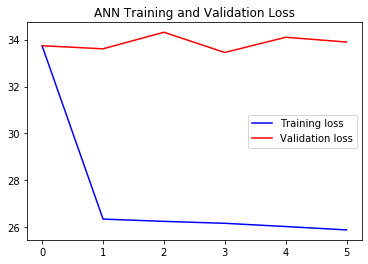

33.894577622413635
31.68000876903534

Validation:
MAPE: 33.894577622413635
MSE: 16926.744
CV(RMSE): 74.59333060263656
MBE: -44.24985

Test:
MAPE: 31.68000876903534
MSE: 13157.151
CV(RMSE): 69.43541806642236
MBE: -34.607468

Fold #2
Train on 253344 samples, validate on 125280 samples
Epoch 1/30
253344/253344 [==============================] - 10s 39us/step - loss: 29.1091 - val_loss: 28.7353
Epoch 2/30
253344/253344 [==============================] - 9s 37us/step - loss: 28.9891 - val_loss: 28.6095
Epoch 3/30
253344/253344 [==============================] - 9s 36us/step - loss: 28.9251 - val_loss: 29.1093
Epoch 4/30
253344/253344 [==============================] - 9s 37us/step - loss: 28.8454 - val_loss: 28.5343
Epoch 5/30
253344/253344 [==============================] - 9s 36us/step - loss: 28.7911 - val_loss: 28.6542
Epoch 6/30
253344/253344 [==============================] - 9s 37us/step - loss: 28.7403 - val_loss: 28.2220
Epoch 7/30
253344/253344 [==============================] - 9

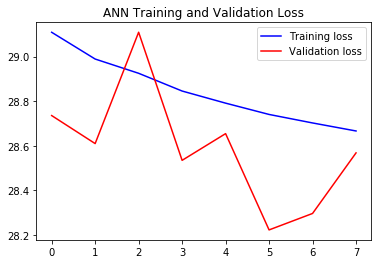

28.567734360694885
32.49371349811554

Validation:
MAPE: 28.567734360694885
MSE: 13668.683
CV(RMSE): 70.77232061128213
MBE: -36.413002

Test:
MAPE: 32.49371349811554
MSE: 18184.482
CV(RMSE): 76.39460136241846
MBE: -48.2129

Fold #3
Train on 379320 samples, validate on 127368 samples
Epoch 1/30
379320/379320 [==============================] - 13s 35us/step - loss: 28.2995 - val_loss: 31.8511
Epoch 2/30
379320/379320 [==============================] - 13s 34us/step - loss: 28.2648 - val_loss: 31.9941
Epoch 3/30
379320/379320 [==============================] - 13s 34us/step - loss: 28.2524 - val_loss: 31.7054
Epoch 4/30
379320/379320 [==============================] - 13s 34us/step - loss: 28.2283 - val_loss: 31.9393
Epoch 5/30
379320/379320 [==============================] - 13s 35us/step - loss: 28.1962 - val_loss: 31.8007


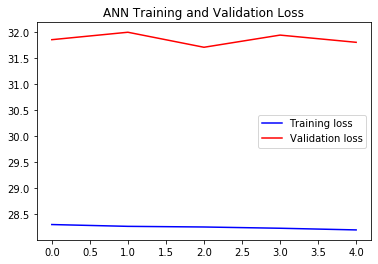

31.800663471221924
27.941566705703735

Validation:
MAPE: 31.800663471221924
MSE: 17303.82
CV(RMSE): 74.52177736100494
MBE: -46.51863

Test:
MAPE: 27.941566705703735
MSE: 11990.173
CV(RMSE): 66.10147977794627
MBE: -35.560307

Fold #4
Train on 507384 samples, validate on 125280 samples
Epoch 1/30
507384/507384 [==============================] - 17s 34us/step - loss: 28.9532 - val_loss: 27.8180
Epoch 2/30
507384/507384 [==============================] - 16s 32us/step - loss: 28.9305 - val_loss: 27.4175
Epoch 3/30
507384/507384 [==============================] - 16s 32us/step - loss: 28.8983 - val_loss: 27.2458
Epoch 4/30
507384/507384 [==============================] - 16s 32us/step - loss: 28.8705 - val_loss: 27.5550
Epoch 5/30
507384/507384 [==============================] - 16s 32us/step - loss: 28.8562 - val_loss: 27.2277
Epoch 6/30
507384/507384 [==============================] - 16s 32us/step - loss: 28.8187 - val_loss: 27.2978
Epoch 7/30
507384/507384 [=============================

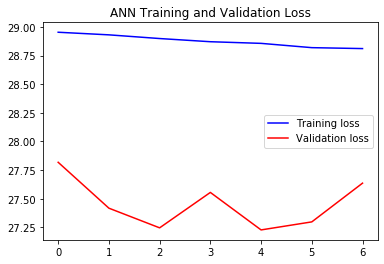

27.635911107063293
27.41178274154663

Validation:
MAPE: 27.635911107063293
MSE: 11672.857
CV(RMSE): 65.22093963767183
MBE: -37.23544

Test:
MAPE: 27.41178274154663
MSE: 17212.264
CV(RMSE): 74.56212891417337
MBE: -48.667408

4-Fold Average

Validation:
MAPE: 30.474721640348434
MSE: 14893.026123046875
CV(RMSE): 71.27709205314886
MBE: -41.104230880737305

Test:
MAPE: 29.88176792860031
MSE: 15136.017578125
CV(RMSE): 71.62340703024012
MBE: -41.762020111083984

Overall Validation:
MAPE: 30.474721640348434
MSE: 14893.026123046875
CV(RMSE): 71.27709205314886
MBE: -41.104230880737305

Overall Test:
MAPE: 29.88176792860031
MSE: 15136.017578125
CV(RMSE): 71.62340703024012
MBE: -41.762020111083984


In [304]:
ann_model = None

n_features = train_folds[0][0].shape[-1]

metrics = np.zeros((2,4))

for i in range(N):
    ann_model = Sequential()
    ann_model.add(Dense(32, activation='relu', input_shape = [n_features]))
    ann_model.add(Dense(32, activation='relu'))
    ann_model.add(Dense(1))
    print("-----Experiment #" + str(i + 1) + "-----")
    metrics = metrics + utils.walk_forward_cv(
        ann_model, 
        train_folds, 
        val_folds, 
        test_folds, 
        callbacks=callbacks, 
        verbose=1, 
        model_name="ANN"
    ) / N

print("\nOverall Validation:")
utils.print_metrics(*metrics[0])
print("\nOverall Test:")
utils.print_metrics(*metrics[1])

In [305]:
test = utils.equalize_timesteps(energy, fold[2], timesteps, one_hot=False)
test = test.filter(items=['apn', 'year', 'month', 'day', 'hour', 'kwh_actual'])
test['kwh_actual'] = test['kwh_actual'].apply(lambda x: np.where(x < 1, 1, x))
test['kwh_baseline'] = ann_model.predict(test_folds[3][0]).ravel()

In [306]:
PATH_TEST = "../data/output_retrofit/test.csv"
test.to_csv(PATH_TEST, index=False) 

In [307]:
# from see_rnn import get_gradients, features_0D, features_1D, features_2D

# grads_all  = get_gradients(lstm_model, 5, val_x[:10], val_y[:10])  # return_sequences=True,  layer index 1
# # grads_last = get_gradients(model, 2, x, y)  # return_sequences=False, layer index 2

# features_1D(grads_all, n_rows=2)
# features_2D(grads_all, n_rows=10, norm=(-.01, .01))
# features_0D(grads_all[1])

# All currently listed 4-fold averages used timesteps=3

In [308]:
# Todos:

# [X] Investigate exploding gradients, using clip values for gradient clipping
# [ ] Visualize per building error distribution
# [X] Implement additional benchmarks (e.g. SVR?)
# [ ] Investigate visualization strategies for LSTM and Conv Layers
# [X] Multiple temporal and spatial scale analysis
# [ ] Investigate domain transfer techniques
# [ ] See what happens with retrofits

In [309]:
import importlib
importlib.reload(utils)

<module 'dues_utilities' from 'C:\\Users\\benchoi\\Projects\\dues\\ml\\dues_utilities.py'>